# Fantasy Football Draft Analysis

Author: Melody Bass

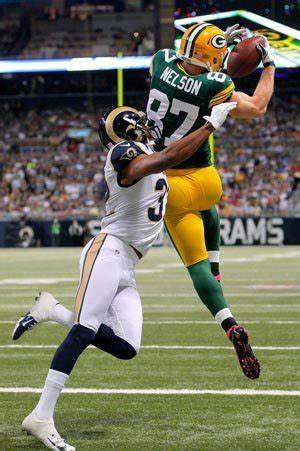

## Overview

## Business Problem

## Data Understanding

In [33]:
# Basics
import pandas as pd
import numpy as np
import itertools

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.pylab import rcParams
import time

# Modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from sklearn.linear_model import LassoLarsCV
from fbprophet import Prophet as proph

# Warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')

In [34]:
# load in player fantasy stats data as player_df
player_df = pd.read_csv('data/league_data/player_data/Yahoo-406.l.12345-Players.csv')
player_df.head()

,ID,OR,Last Name,First Name,Team,Status,Status Details,Eligible Positions,Avg. Pick,Avg. Round,...,Ret TD (DT),XPR (DT),Pts Allow 0 (DT),Pts Allow 1-6 (DT),Pts Allow 7-13 (DT),Pts Allow 14-20 (DT),Pts Allow 21-27 (DT),Pts Allow 28-34 (DT),Pts Allow 35+ (DT),Image
0,406.p.30977,1,Allen,Josh,Buf,Available,NaN,QB,29.7,3.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/JqjwXUxHWb2L...
1,406.p.32676,2,Herbert,Justin,LAC,Available,NaN,QB,61.1,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/j0W7BC4RRiJB...
2,406.p.5228,3,Brady,Tom,TB,Available,NaN,QB,63.5,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/Z71ic_5aqQfG...
3,406.p.30123,4,Mahomes,Patrick,KC,Available,NaN,QB,16.6,2.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/oMIJokh4hdPk...
4,406.p.30182,5,Kupp,Cooper,LAR,Available,NaN,WR,42.0,4.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/hYxm3SR9yMjD...


In [35]:
# load in player fantasy points time series

wr_ts = pd.read_csv('data/wr_ts.csv')
wr_ts = wr_ts.drop('Unnamed: 0', axis=1).fillna(0)

qb_ts = pd.read_csv('data/qb_ts.csv')
qb_ts = qb_ts.drop('Unnamed: 0', axis=1).fillna(0)

rb_ts = pd.read_csv('data/rb_ts.csv')
rb_ts = rb_ts.drop('Unnamed: 0', axis=1).fillna(0)

te_ts = pd.read_csv('data/te_ts.csv')
te_ts = te_ts.drop('Unnamed: 0', axis=1).fillna(0)
qb_ts.tail(20)

,Aaron Rodgers,Dak Prescott,Jalen Hurts,Joe Burrow,Josh Allen,Justin Herbert,Kyler Murray,Lamar Jackson,Matthew Stafford,Patrick Mahomes II,Russell Wilson,Tom Brady,Trey Lance
65,18.3,0.0,37.8,0.0,37.7,28.0,34.1,30.2,15.3,25.9,13.0,23.4,0.0
66,26.1,0.0,20.6,0.0,32.3,16.7,16.4,21.3,0.7,20.2,19.9,29.9,0.0
67,26.0,0.0,17.3,0.0,20.3,33.0,3.8,25.2,23.6,0.0,18.1,31.3,0.0
68,3.3,28.4,28.8,18.6,17.2,14.4,34.6,18.0,24.3,33.3,27.1,29.2,4.4
69,26.8,8.5,21.8,13.3,17.7,16.7,35.1,34.3,18.2,25.0,23.3,29.6,0.0
70,19.0,20.1,22.5,18.6,37.2,30.8,19.5,20.3,29.5,24.9,16.6,28.7,6.1
71,24.1,27.0,28.2,22.3,21.0,21.3,22.6,19.4,20.3,32.3,22.6,11.1,20.4
72,20.8,21.7,23.9,20.3,36.5,42.8,13.7,41.9,17.5,21.0,10.1,37.7,15.6
73,23.7,27.8,26.0,23.8,29.7,12.0,25.8,13.8,26.2,25.0,0.0,19.0,0.0
74,24.7,0.0,23.5,27.6,0.0,0.0,22.4,23.1,27.2,8.7,0.0,24.4,0.0


In [212]:
# load in player fantasy stats data as player_df
qb_snap_ts = pd.read_csv('data/qb_snap_ts.csv')
qb_snap_ts = qb_snap_ts.drop('Unnamed: 0', axis=1).fillna(0)

rb_snap_ts = pd.read_csv('data/rb_snap_ts.csv')
rb_snap_ts = rb_snap_ts.drop('Unnamed: 0', axis=1).fillna(0)

wr_snap_ts = pd.read_csv('data/wr_snap_ts.csv')
wr_snap_ts = wr_snap_ts.drop('Unnamed: 0', axis=1).fillna(0)

te_snap_ts = pd.read_csv('data/te_snap_ts.csv')
te_snap_ts = te_snap_ts.drop('Unnamed: 0', axis=1).fillna(0)

wr_snap_ts.head()

,snaps_A.J. Brown,snaps_Adam Thielen,snaps_Allen Robinson II,snaps_Amari Cooper,snaps_Amon-Ra St. Brown,snaps_Brandin Cooks,snaps_Brandon Aiyuk,snaps_CeeDee Lamb,snaps_Chris Godwin,snaps_Christian Kirk,...,snaps_Michael Thomas,snaps_Mike Evans,snaps_Mike Williams,snaps_Rashod Bateman,snaps_Robert Woods,snaps_Stefon Diggs,snaps_Tee Higgins,snaps_Terry McLaurin,snaps_Tyler Lockett,snaps_Tyreek Hill
0,0.0,65.0,3.0,61.0,0.0,67.0,0.0,0.0,0.0,0.0,...,58.0,0.0,0.0,0.0,43.0,58.0,0.0,0.0,26.0,50.0
1,0.0,62.0,0.0,48.0,0.0,65.0,0.0,0.0,29.0,0.0,...,58.0,55.0,0.0,0.0,45.0,60.0,0.0,0.0,61.0,47.0
2,0.0,63.0,0.0,44.0,0.0,57.0,0.0,0.0,11.0,0.0,...,46.0,47.0,0.0,0.0,60.0,52.0,0.0,0.0,66.0,39.0
3,0.0,55.0,0.0,53.0,0.0,64.0,0.0,0.0,9.0,0.0,...,69.0,59.0,0.0,0.0,59.0,48.0,0.0,0.0,50.0,58.0
4,0.0,68.0,0.0,55.0,0.0,72.0,0.0,0.0,17.0,0.0,...,0.0,68.0,0.0,0.0,64.0,49.0,0.0,0.0,38.0,46.0


## EDA

### Seasonality EDA

### Discussion on EDA

## SARIMAX Modeling

### Create Individual Time Series

In [37]:
qb_list = []
for col in qb_ts.columns:
    player = qb_ts[col].squeeze()
    qb_list.append(player)
     
qb_list_names = []
for col in qb_ts.columns:
    player = col
    qb_list_names.append(player)

qb_list_snaps = []
for col in qb_snap_ts.columns:
    player = qb_snap_ts[col].squeeze()
    qb_list_snaps.append(player)
    
qb_list_snaps[0]    

0     82.0
1     76.0
2     70.0
3     52.0
4     60.0
      ... 
80     0.0
81    63.0
82    62.0
83    59.0
84    63.0
Name: snaps_Aaron Rodgers, Length: 85, dtype: float64

In [220]:
wr_list = []
for col in wr_ts.columns:
    player = wr_ts[col].squeeze()
    wr_list.append(player)
     
wr_list_names = []
for col in wr_ts.columns:
    player = col
    wr_list_names.append(player)

wr_list_snaps = []
for col in wr_snap_ts.columns:
    player = wr_snap_ts[col].squeeze()
    wr_list_snaps.append(player)
    

In [236]:
rb_list = []
for col in rb_ts.columns:
    player = rb_ts[col].squeeze()
    rb_list.append(player)
     
rb_list_names = []
for col in rb_ts.columns:
    player = col
    rb_list_names.append(player)

rb_list_snaps = []
for col in rb_snap_ts.columns:
    player = rb_snap_ts[col].squeeze()
    rb_list_snaps.append(player)

In [237]:
te_list = []
for col in te_ts.columns:
    player = te_ts[col].squeeze()
    te_list.append(player)
     
te_list_names = []
for col in te_ts.columns:
    player = col
    te_list_names.append(player)

te_list_snaps = []
for col in te_snap_ts.columns:
    player = te_snap_ts[col].squeeze()
    te_list_snaps.append(player)

### Seasonal Decompostion

In [38]:
def decomposition_plot(ts):
    decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=16)

    #Gather the trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(ts, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout();
    return decomposition_plot

<function __main__.decomposition_plot(ts)>

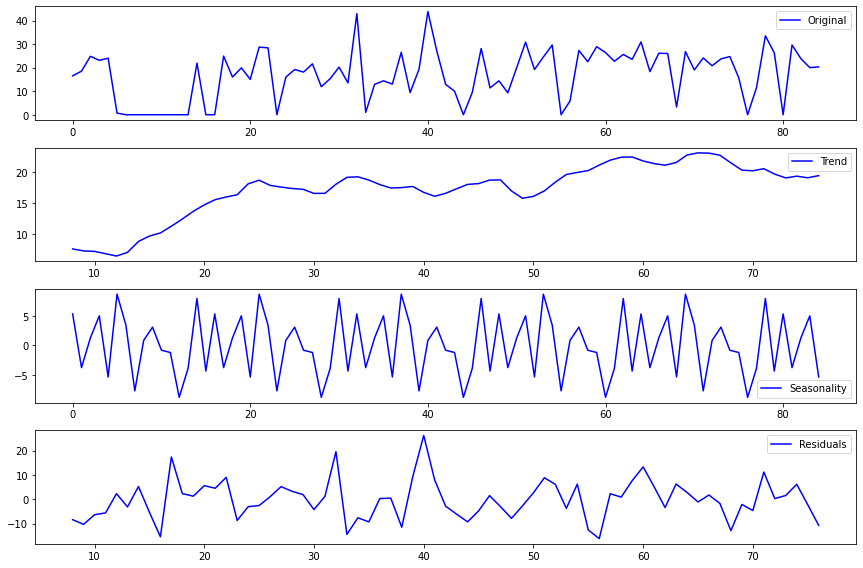

In [39]:
#Decomposition plot of the Arena District
decomposition_plot(qb_list[0])

In [40]:
qb_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Aaron Rodgers       85 non-null     float64
 1   Dak Prescott        85 non-null     float64
 2   Jalen Hurts         85 non-null     float64
 3   Joe Burrow          85 non-null     float64
 4   Josh Allen          85 non-null     float64
 5   Justin Herbert      85 non-null     float64
 6   Kyler Murray        85 non-null     float64
 7   Lamar Jackson       85 non-null     float64
 8   Matthew Stafford    85 non-null     float64
 9   Patrick Mahomes II  85 non-null     float64
 10  Russell Wilson      85 non-null     float64
 11  Tom Brady           85 non-null     float64
 12  Trey Lance          85 non-null     float64
dtypes: float64(13)
memory usage: 8.8 KB


### Stationarity Check

In [41]:
def stationarity_check(TS):
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [42]:
# Get decomposition for stationarity check
decomposition = sm.tsa.seasonal_decompose(qb_list[0], model='additive', period=16)
residual = decomposition.resid
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

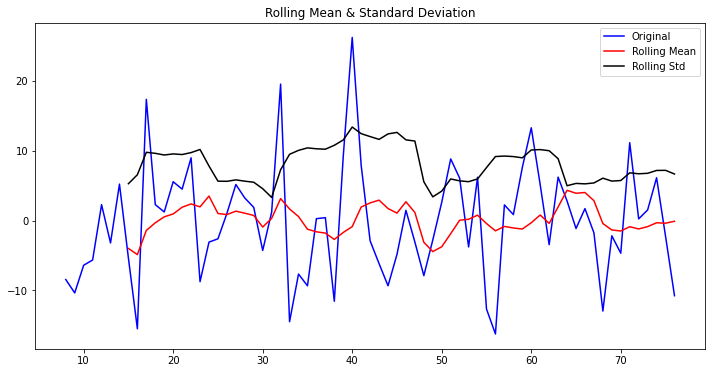

Results of Dickey-Fuller Test: 

Test Statistic                 -5.403261
p-value                         0.000003
#Lags Used                      5.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


In [43]:
stationarity_check(ts_log_decompose)

The p-value is <0.05, which means we accept the null hypothesis that the residuals are stationary. We can move on to check our autocorrelation and partial autocorrelation plots.

### Autocorrelation and Partial Autocorrelation

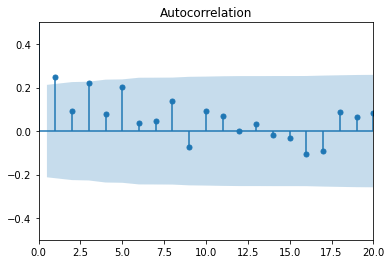

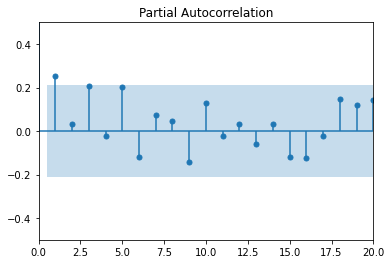

In [44]:
plot_acf(qb_list[0]); plt.xlim(0,20); plt.ylim(-0.5,0.5);plt.show()
plot_pacf(qb_list[0]); plt.xlim(0,20); plt.ylim(-0.5,0.5);plt.show()

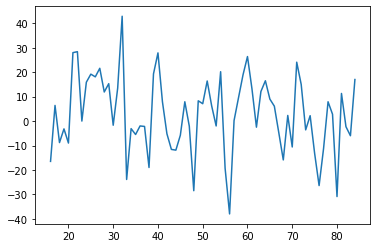

In [45]:
qb_list[0].diff(periods=16).plot();

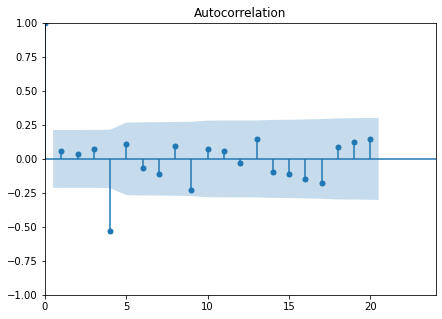

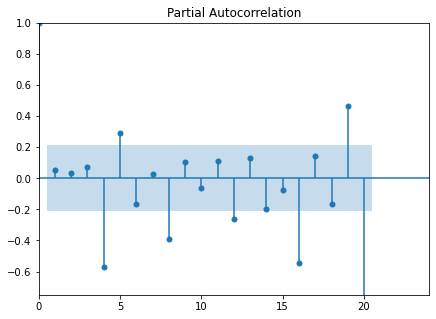

In [46]:
rcParams['figure.figsize']=7,5
plot_acf(qb_list[0].diff(periods=4).bfill()); plt.xlim(0,24); plt.show()
plot_pacf(qb_list[0].diff(periods=4).bfill()); plt.xlim(0,24); plt.ylim(-0.75,1);plt.show()

### Gridsearch for SARIMAX Model

Next, I am going to conduct gridsearch to find optimal values for (p,d,q) and (P,D,Q,s) ranked by lowest AIC. This will provide optimal parameters for each of my players for Sarimax modeling. 

In [234]:
def gridsearch(ts, player_name, player_snaps):

    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = [(x[0], x[1], x[2], 0) for x in list(itertools.product(p, d, q))]
    
    # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for df, name, snaps in zip(ts, player_name, player_snaps):
            for comb in pdq:
                for combs in pdqs:
                    try:
                        mod = sm.tsa.statespace.SARIMAX(df,
                                                        exog=snaps,
                                                        order=comb,
                                                        seasonal_order=combs,
                                                        enforce_stationarity=False,
                                                        enforce_invertibility=False)

                        output = mod.fit()
                        ans.append([name, comb, combs, output.aic])
                    except:
                        continue
                        
    # Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['name', 'pdq', 'pdqs', 'aic'])            
    #Return the best set of parameters based on AIC
    best_para = ans_df.loc[ans_df.groupby("name")["aic"].idxmin()]
    return best_para

In [235]:
gridsearch(qb_list, qb_list_names, qb_list_snaps)

,name,pdq,pdqs,aic
3,Aaron Rodgers,"(0, 1, 1)","(0, 0, 0, 0)",564.916297
11,Dak Prescott,"(0, 1, 1)","(0, 0, 0, 0)",573.703541
17,Jalen Hurts,"(0, 0, 1)","(0, 0, 0, 0)",398.941068
31,Joe Burrow,"(1, 1, 1)","(0, 0, 0, 0)",477.136270
35,Josh Allen,"(0, 1, 1)","(0, 0, 0, 0)",557.924810
41,Justin Herbert,"(0, 0, 1)","(0, 0, 0, 0)",499.676421
49,Kyler Murray,"(0, 0, 1)","(0, 0, 0, 0)",520.353682
59,Lamar Jackson,"(0, 1, 1)","(0, 0, 0, 0)",552.386860
67,Matthew Stafford,"(0, 1, 1)","(0, 0, 0, 0)",523.712595
79,Patrick Mahomes II,"(1, 1, 1)","(0, 0, 0, 0)",557.790588


In [238]:
gridsearch(wr_list, wr_list_names, wr_list_snaps)

,name,pdq,pdqs,aic
5,A.J. Brown,"(1, 0, 1)","(0, 0, 0, 0)",536.472787
9,Adam Thielen,"(0, 0, 1)","(0, 0, 0, 0)",569.221609
19,Allen Robinson II,"(0, 1, 1)","(0, 0, 0, 0)",538.630323
31,Amari Cooper,"(1, 1, 1)","(0, 0, 0, 0)",605.248293
37,Amon-Ra St. Brown,"(1, 0, 1)","(0, 0, 0, 0)",365.599062
43,Brandin Cooks,"(0, 1, 1)","(0, 0, 0, 0)",571.388858
51,Brandon Aiyuk,"(0, 1, 1)","(0, 0, 0, 0)",446.114017
61,CeeDee Lamb,"(1, 0, 1)","(0, 0, 0, 0)",476.992648
69,Chris Godwin,"(1, 0, 1)","(0, 0, 0, 0)",570.450856
75,Christian Kirk,"(0, 1, 1)","(0, 0, 0, 0)",541.795791


In [239]:
gridsearch(rb_list, rb_list_names, rb_list_snaps)

,name,pdq,pdqs,aic
5,AJ Dillon,"(1, 0, 1)","(0, 0, 0, 0)",394.976698
15,Aaron Jones,"(1, 1, 1)","(0, 0, 0, 0)",599.557419
19,Alvin Kamara,"(0, 1, 1)","(0, 0, 0, 0)",623.373227
25,Antonio Gibson,"(0, 0, 1)","(0, 0, 0, 0)",451.794207
35,Austin Ekeler,"(0, 1, 1)","(0, 0, 0, 0)",549.734524
40,Breece Hall,"(0, 0, 0)","(0, 0, 0, 0)",-1775.789805
53,Cam Akers,"(1, 0, 1)","(0, 0, 0, 0)",413.782224
63,Chase Edmonds,"(1, 1, 1)","(0, 0, 0, 0)",551.914039
67,Christian McCaffrey,"(0, 1, 1)","(0, 0, 0, 0)",643.160118
79,Clyde Edwards-Helaire,"(1, 1, 1)","(0, 0, 0, 0)",513.615290


In [240]:
gridsearch(te_list, te_list_names, te_list_snaps)

,name,pdq,pdqs,aic
1,Dallas Goedert,"(0, 0, 1)","(0, 0, 0, 0)",491.422922
9,Dalton Schultz,"(0, 0, 1)","(0, 0, 0, 0)",483.282841
21,Darren Waller,"(1, 0, 1)","(0, 0, 0, 0)",508.536732
25,Dawson Knox,"(0, 0, 1)","(0, 0, 0, 0)",450.648002
37,George Kittle,"(1, 0, 1)","(0, 0, 0, 0)",570.094026
43,Kyle Pitts,"(0, 1, 1)","(0, 0, 0, 0)",420.154661
55,Mark Andrews,"(1, 1, 1)","(0, 0, 0, 0)",557.247354
59,T.J. Hockenson,"(0, 1, 1)","(0, 0, 0, 0)",479.255227
67,Travis Kelce,"(0, 1, 1)","(0, 0, 0, 0)",565.249889
75,Zach Ertz,"(0, 1, 1)","(0, 0, 0, 0)",560.674912


### Best Parameters SARIMAX Model

Now that we have our optimal parameters for each zip code from our gridsearch, we will use the to build a sarimax model for each zip code.  Following are 3 functions we will use to build, evaluate and test each model, and forecast predictions for each of our top 10 zip codes.

#### Functions for Modeling

In [51]:
# Define function to build SARIMAX model, print summary and output diagnostic plots
def sarimax(ts, exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 17)):
    '''
    Input: 
    ts : Time series data.
    order : (p, d, q) values for ARIMA. Default = (1, 1, 1)
    seasonal_order : Seasonal (P, D, Q, s) values for SARIMA.
        Default = (1, 1, 1, 12).
        
    Output:
    Prints model output summary.
    Plots model diagnostics.
    
    Returns: Model output.
    '''
    
    # Sarimax model
    SARIMAX = sm.tsa.statespace.SARIMAX(ts,
                                        exog=exog,
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
                                            
    # Fit the model and print results
    output = SARIMAX.fit()
    
    # Print output summary
    print(output.summary().tables[1])
    output.plot_diagnostics(figsize=(15,18));
    
    return output

In [248]:
def ose_forecast(ts, output, exog, player =''):
    '''
    Plot forecast with real and predicted data.
    
    Input:
        ts : Time series.
        output : SARIMAX model output. 
        neighborhood : Name of city for plot title. 
        
    Output:
        Prints RMSE.
        Plots real vs. model predicted plot.
    '''

    # Get predictions starting from 2019-06-30 and calculate confidence intervals
    
    pred = output.get_prediction(start=70, exog=exog, dynamic=False)
        
    # Get the real and predicted values
    ts_forecasted = pred.predicted_mean
    ts_truth = ts[70:].values
    
    # Calc RMSE
    mse = mean_squared_error(ts_truth, ts_forecasted)
    rmse = np.sqrt(mse)

    # Print RMSE
    print('The RMSE of our forecasts is {}'.format(round(rmse, 2)))

    # Confidence Intervals
    pred_conf = pred.conf_int()

    ### Plot real vs predicted w/ confidence intervals ###

    rcParams['figure.figsize'] = 15, 6

    # Plot observed values
    ax = ts[25:].plot(label='observed')

    # Plot predicted values
    
    ts_forecasted.plot(ax=ax, label='one-step ahead forecast', alpha=0.5)

    # Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.3)
        
    # Title
    ax.set_title(player)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Home Value (USD)')
    plt.legend()

    return plt.show()

In [53]:
qb_snap_ts.describe()

,snaps_Aaron Rodgers,snaps_Dak Prescott,snaps_Jalen Hurts,snaps_Joe Burrow,snaps_Josh Allen,snaps_Justin Herbert,snaps_Kyler Murray,snaps_Lamar Jackson,snaps_Matthew Stafford,snaps_Patrick Mahomes II,snaps_Russell Wilson,snaps_Tom Brady,snaps_Trey Lance
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,52.388235,54.647059,15.141176,20.188235,45.011765,25.823529,34.988235,38.611765,53.647059,47.423529,59.000000,64.176471,2.094118
std,27.355288,28.663776,27.258530,31.086092,31.148070,34.693617,34.228050,33.116711,24.896790,31.651892,21.067352,18.135847,10.503541
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56.000000,0.000000,57.000000,61.000000,0.000000
50%,62.000000,66.000000,0.000000,0.000000,61.000000,0.000000,46.000000,54.000000,61.000000,61.000000,63.000000,68.000000,0.000000
75%,70.000000,71.000000,5.000000,55.000000,68.000000,66.000000,67.000000,68.000000,68.000000,70.000000,70.000000,74.000000,0.000000
max,90.000000,99.000000,83.000000,92.000000,87.000000,87.000000,88.000000,98.000000,84.000000,98.000000,84.000000,87.000000,65.000000


In [54]:
# Forecast 5 year predictions - Home Sale Values #

def dynamic_forecast(ts, model_output, exog, steps, player='', save_fig=False):
    '''
    Plots dynamic forecast for specified time into the future.
    
    Inputs: 
        ts : Time series data.
        model_output : Output results from our model.
        years : n-years to forcast into the future.
        neighborhood: Name of neighborhood for plots
            
    Outputs:
        Prints : Time series plot with one step ahead forecast.
        Returns : Dictionary of predictions.
    
    '''
    
    # Get forecast and confidence interval for steps ahead in future
    future = model_output.get_forecast(steps=steps, exog=exog, dynamic=True)
    future_conf = future.conf_int()
    
    ### Plot forecast ###
    
    # Observed
    ax = ts.plot(label='Observed', figsize=(12, 6))
    # Predicted
    future.predicted_mean.plot(ax=ax, label='dynamic forecast', alpha=0.9)

    # Confidence Intervals
    ax.fill_between(future_conf.index,
                    future_conf.iloc[:, 0],
                    future_conf.iloc[:, 1], color='k', alpha=.25)
    
    # Title
    ax.set_title(f"1 Year Forecast for {player}")
    
    # x & y-labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Home Sale Value (USD)')
    
    # Legend
    ax.legend()
    
    if save_fig:
        plt.savefig(f'./images/dynamic_forecast_{player}.jpeg')
    
    # Print plot
    plt.show()

    # Forecast prediction for n-years into the future
    forecast = future.predicted_mean
    maximum = future_conf.iloc[-1,1]
    minimum = future_conf.iloc[-1,0]
    
    # Create dictionary of predictions
    predictions = {}
    predictions['forecast'] = forecast.round()
    predictions['minimum'] = minimum.round()
    predictions['maximum'] = maximum.round()
    
    return predictions

#### Aaron Rodgers

                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
snaps_Aaron Rodgers     0.3009      0.037      8.070      0.000       0.228       0.374
ma.L1                  -0.9681      0.053    -18.318      0.000      -1.072      -0.865
sigma2                 52.0669      6.946      7.496      0.000      38.453      65.680


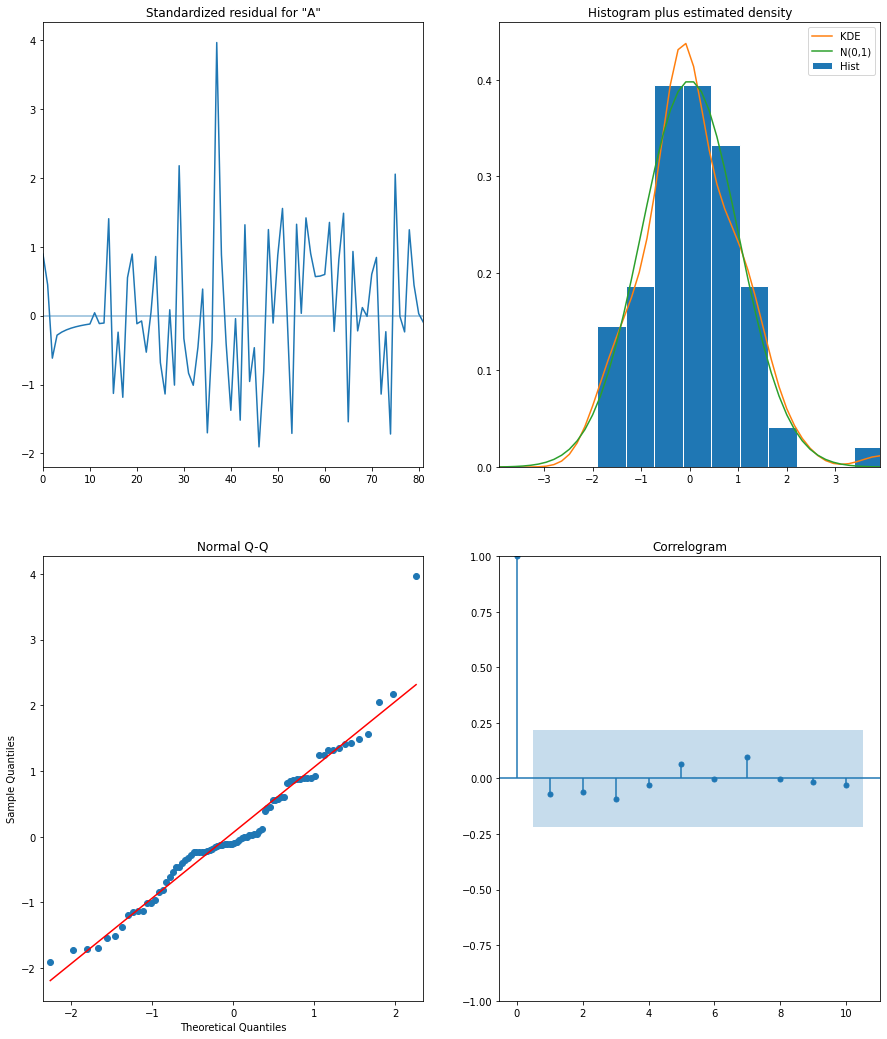

In [184]:
 AR_output = sarimax(qb_list[0], qb_list_snaps[0], order=(0, 1, 1), seasonal_order=(0, 0, 0, 0))

The RMSE of our forecasts is 6.31


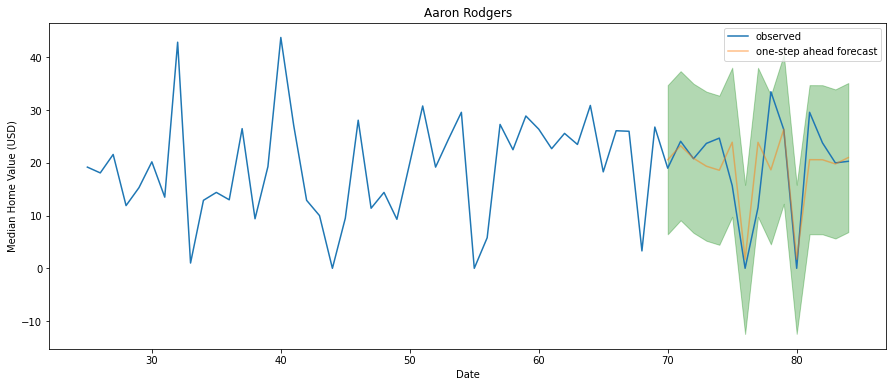

In [185]:
ose_forecast(qb_list[0], AR_output, qb_list_snaps[0][70:], player ='Aaron Rodgers')

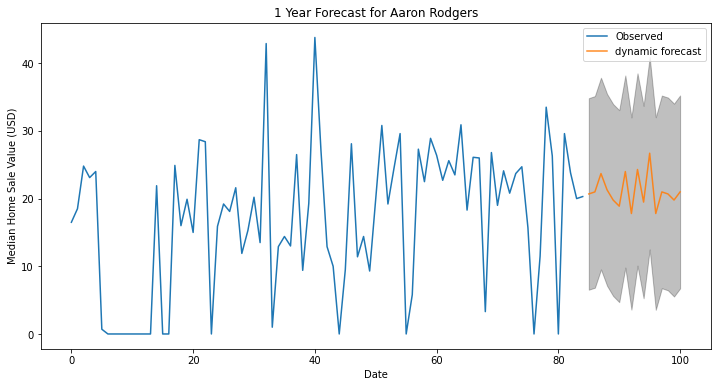

{'forecast': 85     21.0
 86     21.0
 87     24.0
 88     21.0
 89     20.0
 90     19.0
 91     24.0
 92     18.0
 93     24.0
 94     19.0
 95     27.0
 96     18.0
 97     21.0
 98     21.0
 99     20.0
 100    21.0
 Name: predicted_mean, dtype: float64,
 'minimum': 7.0,
 'maximum': 35.0}

In [186]:
dynamic_forecast(qb_list[0], AR_output, qb_list_snaps[0][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[0].mean()),
                 16, player='Aaron Rodgers', save_fig=False)


In [193]:
best_para

,name,pdq,pdqs,aic
3,Aaron Rodgers,"(0, 1, 1)","(0, 0, 0, 0)",628.601789
11,Dak Prescott,"(0, 1, 1)","(0, 0, 0, 0)",632.137618
23,Jalen Hurts,"(1, 1, 1)","(0, 0, 0, 0)",521.944950
31,Joe Burrow,"(1, 1, 1)","(0, 0, 0, 0)",540.091204
35,Josh Allen,"(0, 1, 1)","(0, 0, 0, 0)",615.486900
43,Justin Herbert,"(0, 1, 1)","(0, 0, 0, 0)",567.453035
51,Kyler Murray,"(0, 1, 1)","(0, 0, 0, 0)",602.804424
59,Lamar Jackson,"(0, 1, 1)","(0, 0, 0, 0)",608.302332
71,Matthew Stafford,"(1, 1, 1)","(0, 0, 0, 0)",592.591472
75,Patrick Mahomes II,"(0, 1, 1)","(0, 0, 0, 0)",626.732379


#### Dak Prescott

                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
snaps_Dak Prescott     0.2899      0.013     21.676      0.000       0.264       0.316
ar.L1                  0.0948      0.107      0.885      0.376      -0.115       0.305
sigma2                56.3401      8.679      6.492      0.000      39.330      73.350


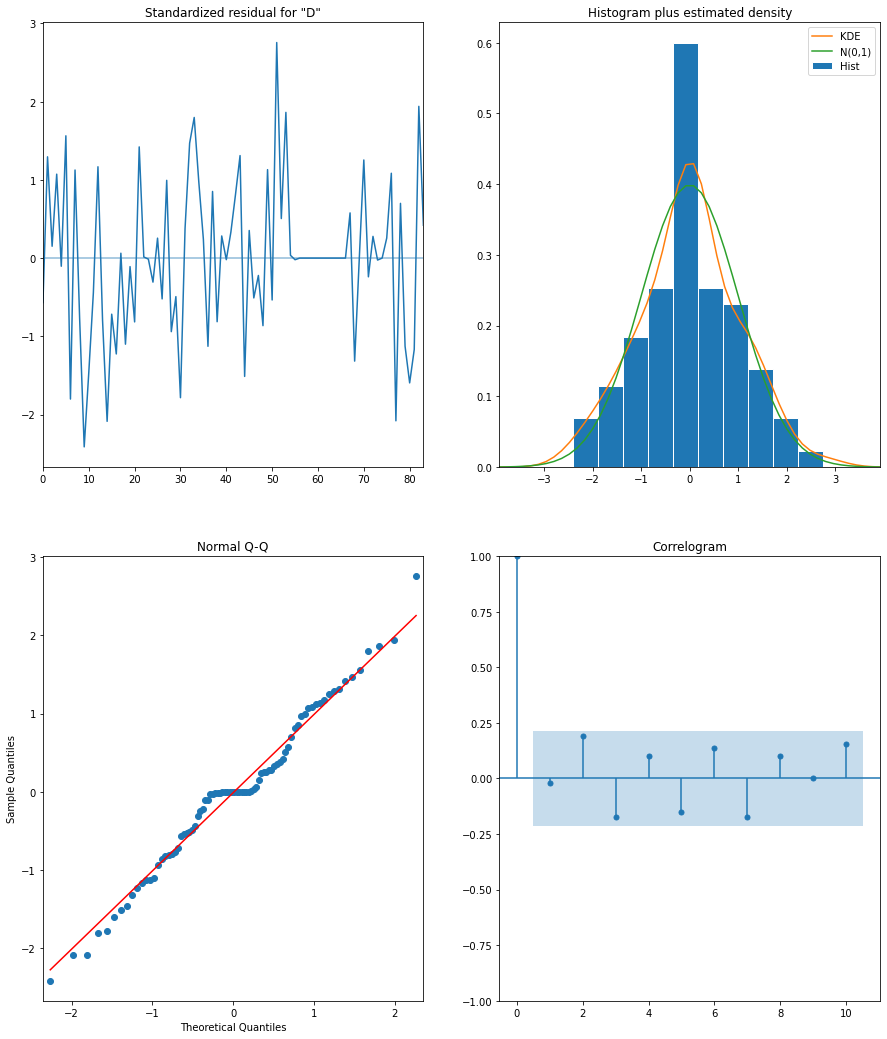

In [187]:
DP_output = sarimax(qb_list[1], qb_list_snaps[1], order=(1, 0, 0), seasonal_order=(0, 0, 0, 0))

The RMSE of our forecasts is 7.97


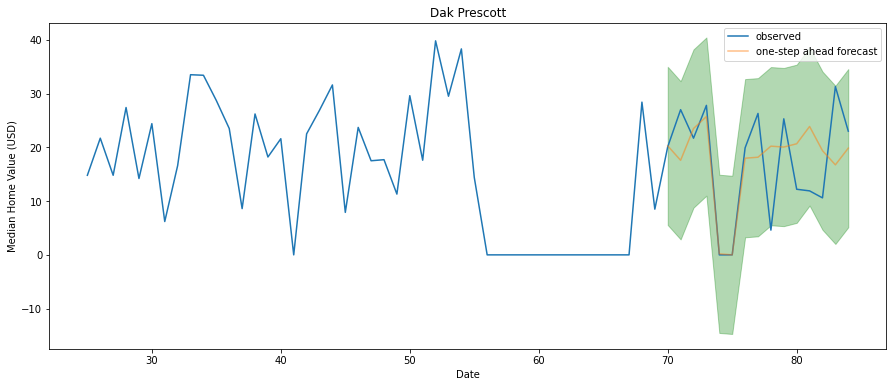

In [188]:
ose_forecast(qb_list[1], DP_output, qb_list_snaps[1][70:], player ='Dak Prescott')

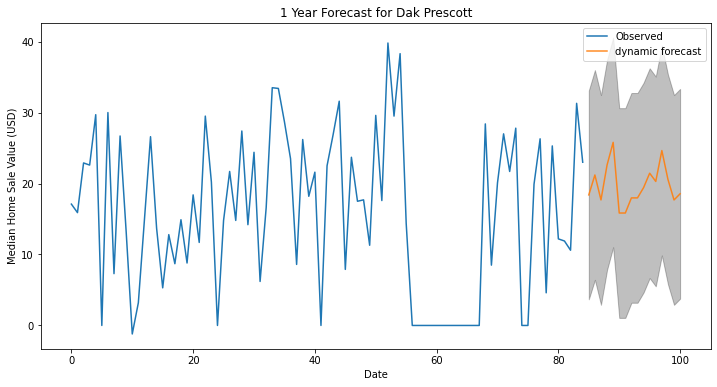

{'forecast': 85     18.0
 86     21.0
 87     18.0
 88     23.0
 89     26.0
 90     16.0
 91     16.0
 92     18.0
 93     18.0
 94     19.0
 95     21.0
 96     20.0
 97     25.0
 98     21.0
 99     18.0
 100    19.0
 Name: predicted_mean, dtype: float64,
 'minimum': 4.0,
 'maximum': 33.0}

In [189]:
dynamic_forecast(qb_list[1], DP_output, qb_list_snaps[1][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[1].mean()),
                 16, player='Dak Prescott', save_fig=False)


#### Jalen Hurts

                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
snaps_Jalen Hurts     0.3462      0.007     51.260      0.000       0.333       0.359
ma.L1                -0.1840      0.148     -1.246      0.213      -0.473       0.105
ma.S.L17             -3.1155      5.006     -0.622      0.534     -12.927       6.696
sigma2                1.0915      3.572      0.306      0.760      -5.909       8.092


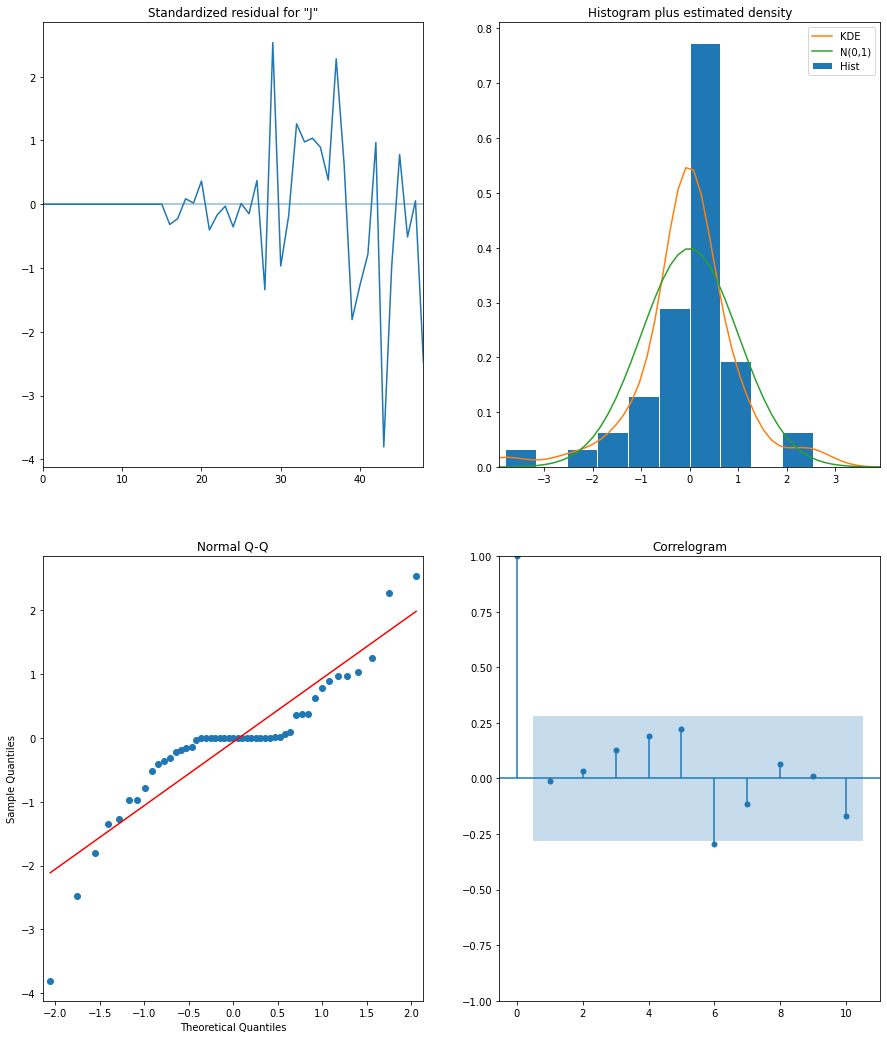

In [62]:
JH_output = sarimax(qb_list[2], qb_list_snaps[2], order=(0, 0, 1), seasonal_order=(0, 1, 1, 17))

The RMSE of our forecasts is 5.08


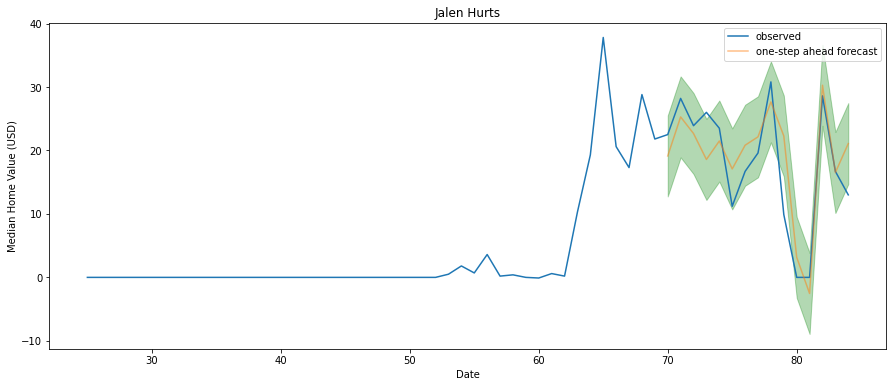

In [63]:
ose_forecast(qb_list[2], JH_output, qb_list_snaps[2][70:], player ='Jalen Hurts')

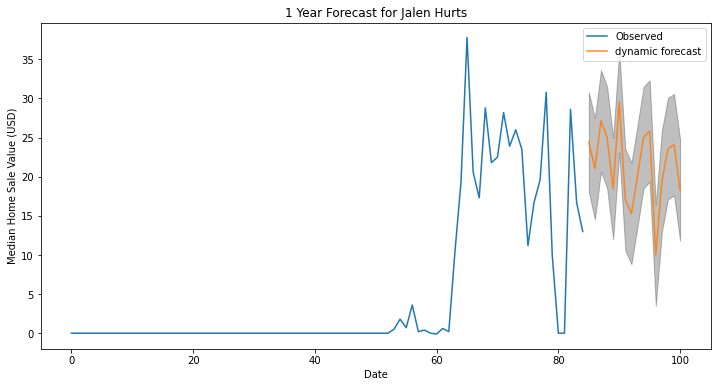

{'forecast': 85     24.0
 86     21.0
 87     27.0
 88     25.0
 89     18.0
 90     30.0
 91     17.0
 92     15.0
 93     20.0
 94     25.0
 95     26.0
 96     10.0
 97     19.0
 98     24.0
 99     24.0
 100    18.0
 Name: predicted_mean, dtype: float64,
 'minimum': 12.0,
 'maximum': 25.0}

In [64]:
dynamic_forecast(qb_list[2], JH_output, qb_list_snaps[2][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[2][-16:].mean()),
                 16, player='Jalen Hurts', save_fig=False)


#### Joe Burrow

                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
snaps_Joe Burrow     0.2784      0.016     17.881      0.000       0.248       0.309
ma.L1                0.2201      0.105      2.101      0.036       0.015       0.425
ma.S.L17            -0.5460      0.296     -1.846      0.065      -1.126       0.034
sigma2              28.9820      4.526      6.404      0.000      20.112      37.852


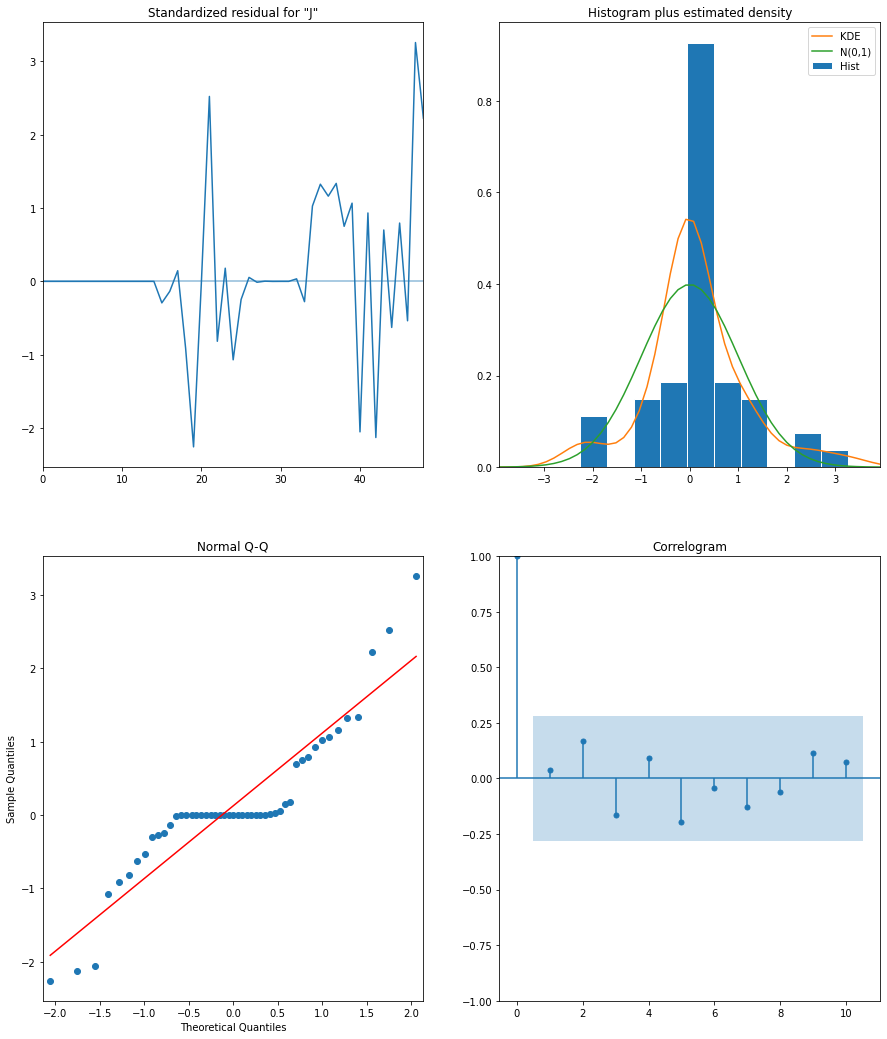

In [65]:
JB_output = sarimax(qb_list[3], qb_list_snaps[3], order=(0, 0, 1), seasonal_order=(0, 1, 1, 17))

The RMSE of our forecasts is 8.2


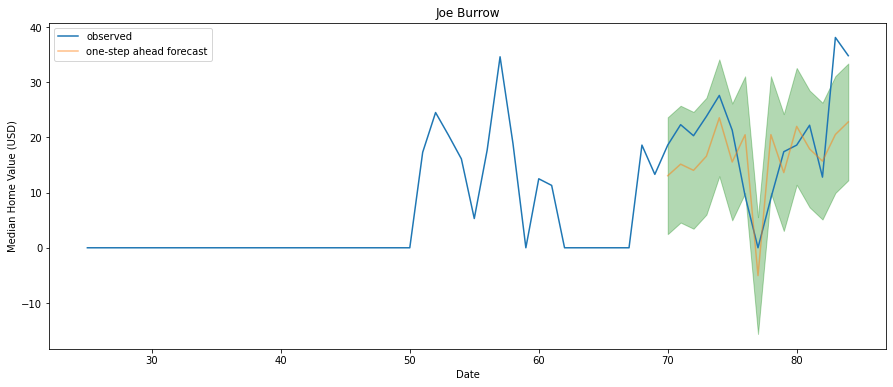

In [66]:
ose_forecast(qb_list[3], JB_output, qb_list_snaps[3][70:], player ='Joe Burrow')

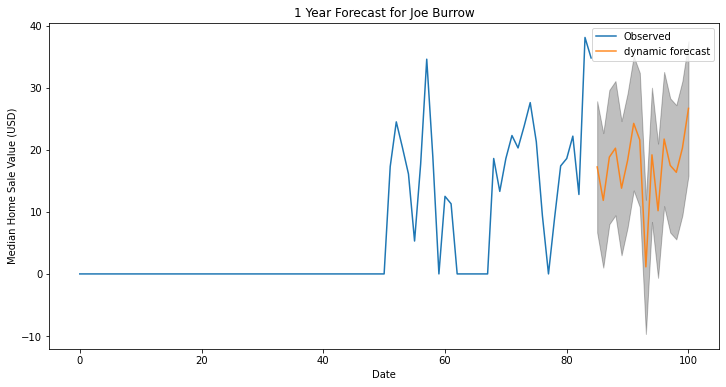

{'forecast': 85     17.0
 86     12.0
 87     19.0
 88     20.0
 89     14.0
 90     18.0
 91     24.0
 92     22.0
 93      1.0
 94     19.0
 95     10.0
 96     22.0
 97     17.0
 98     16.0
 99     20.0
 100    27.0
 Name: predicted_mean, dtype: float64,
 'minimum': 16.0,
 'maximum': 37.0}

In [67]:
dynamic_forecast(qb_list[3], JB_output, qb_list_snaps[3][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[3].mean()),
                 16, player='Joe Burrow', save_fig=False)


#### Josh Allen

                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
snaps_Josh Allen     0.3168      0.073      4.335      0.000       0.174       0.460
ar.L1                0.2538      0.866      0.293      0.770      -1.444       1.952
ma.L1               -0.0767      0.879     -0.087      0.930      -1.799       1.645
ar.S.L16            -0.3648      0.340     -1.073      0.283      -1.031       0.302
ma.S.L16            -0.2804      0.393     -0.713      0.476      -1.052       0.491
sigma2              67.5484     12.652      5.339      0.000      42.751      92.346


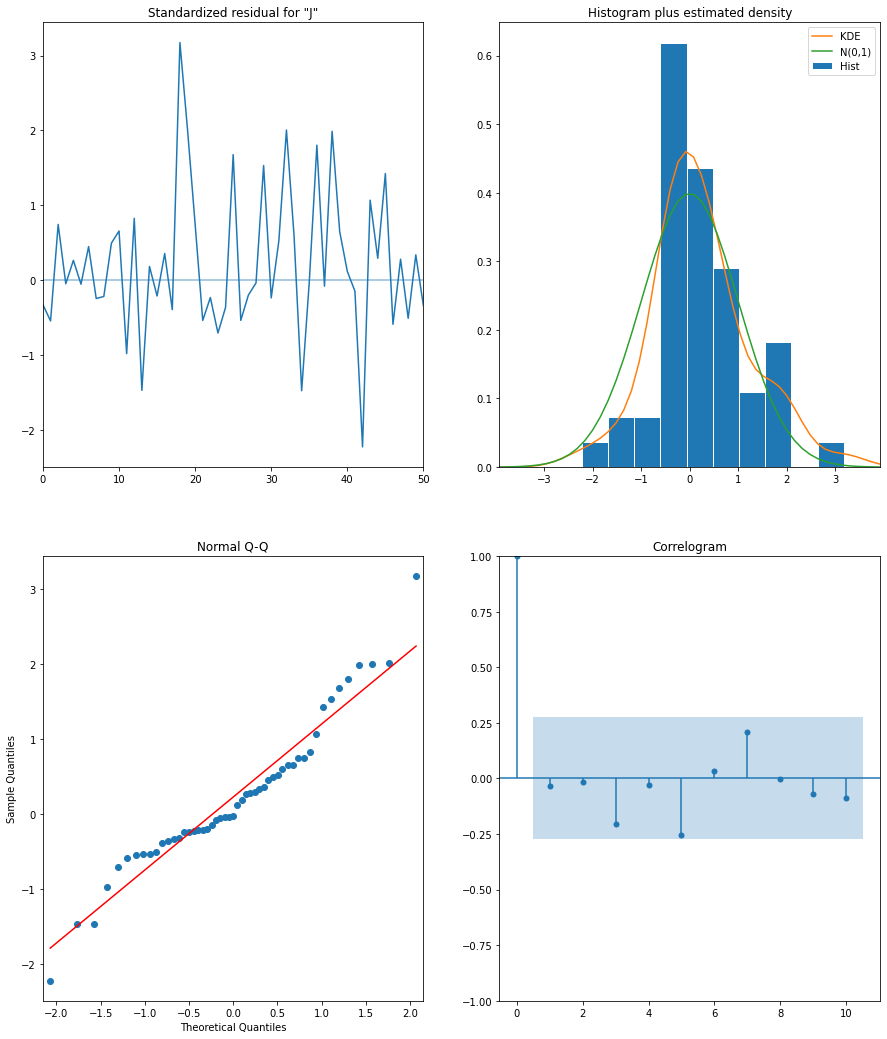

In [68]:
JA_output = sarimax(qb_list[4], qb_list_snaps[4], order=(1, 0, 1), seasonal_order=(1, 1, 1, 16))

The RMSE of our forecasts is 8.7


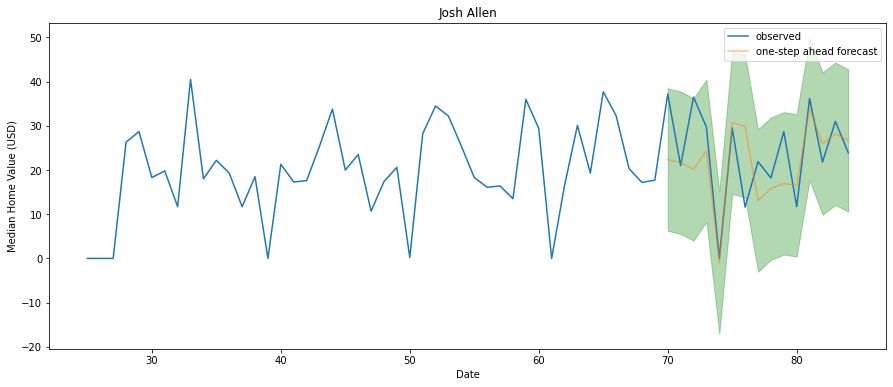

In [69]:
ose_forecast(qb_list[4], JA_output, qb_list_snaps[4][70:], player ='Josh Allen')

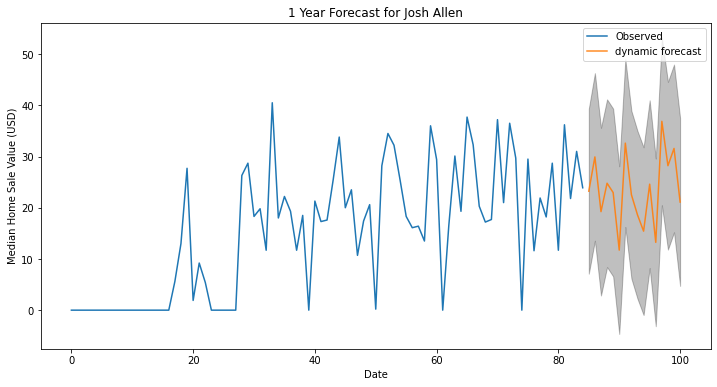

{'forecast': 85     23.0
 86     30.0
 87     19.0
 88     25.0
 89     23.0
 90     12.0
 91     33.0
 92     23.0
 93     19.0
 94     15.0
 95     25.0
 96     13.0
 97     37.0
 98     28.0
 99     32.0
 100    21.0
 Name: predicted_mean, dtype: float64,
 'minimum': 5.0,
 'maximum': 37.0}

In [70]:
dynamic_forecast(qb_list[4], JA_output, qb_list_snaps[4][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[4].mean()),
                 16, player='Josh Allen', save_fig=False)


#### Justin Herbert

                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
snaps_Justin Herbert     0.3226      0.022     14.705      0.000       0.280       0.366
ma.L1                   -1.0000    743.956     -0.001      0.999   -1459.128    1457.127
ar.S.L17                -1.2097      3.459     -0.350      0.727      -7.989       5.569
ma.S.L17                 0.0442      3.448      0.013      0.990      -6.713       6.801
sigma2                  39.2029   2.92e+04      0.001      0.999   -5.71e+04    5.72e+04


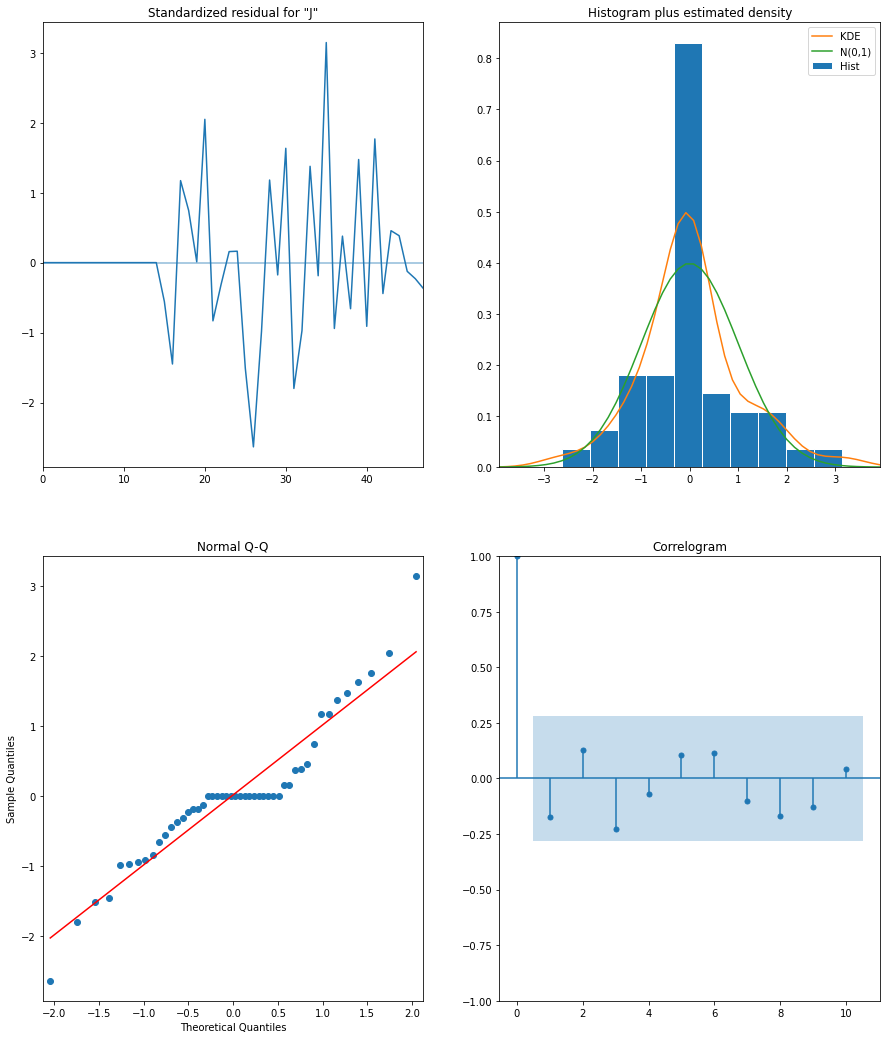

In [71]:
JH2_output = sarimax(qb_list[5], qb_list_snaps[5], order=(0, 1, 1), seasonal_order=(1, 1, 1, 17))

The RMSE of our forecasts is 7.35


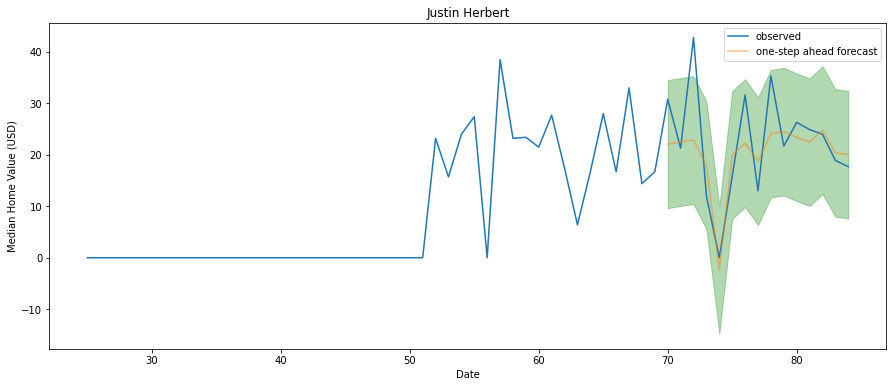

In [72]:
ose_forecast(qb_list[5], JH2_output, qb_list_snaps[5][70:], player ='Justin Herbert')

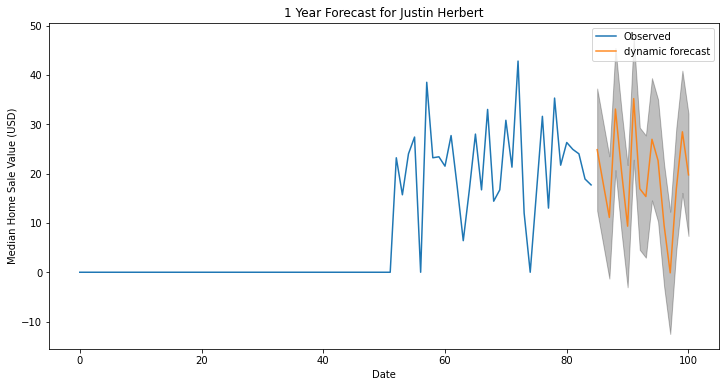

{'forecast': 85     25.0
 86     18.0
 87     11.0
 88     33.0
 89     20.0
 90      9.0
 91     35.0
 92     17.0
 93     15.0
 94     27.0
 95     23.0
 96      9.0
 97     -0.0
 98     17.0
 99     28.0
 100    20.0
 Name: predicted_mean, dtype: float64,
 'minimum': 7.0,
 'maximum': 32.0}

In [73]:
dynamic_forecast(qb_list[5], JH2_output, qb_list_snaps[5][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[5].mean()),
                 16, player='Justin Herbert', save_fig=False)


#### Kyler Murray

                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
snaps_Kyler Murray     0.3429      0.055      6.191      0.000       0.234       0.451
ar.L1                  0.1928      0.147      1.308      0.191      -0.096       0.482
ma.L1                 -1.0000    434.067     -0.002      0.998    -851.755     849.755
ar.S.L16              -0.4275      0.304     -1.406      0.160      -1.024       0.169
ma.S.L16              -1.0003    835.572     -0.001      0.999   -1638.691    1636.690
sigma2                32.3291   2.97e+04      0.001      0.999   -5.81e+04    5.82e+04


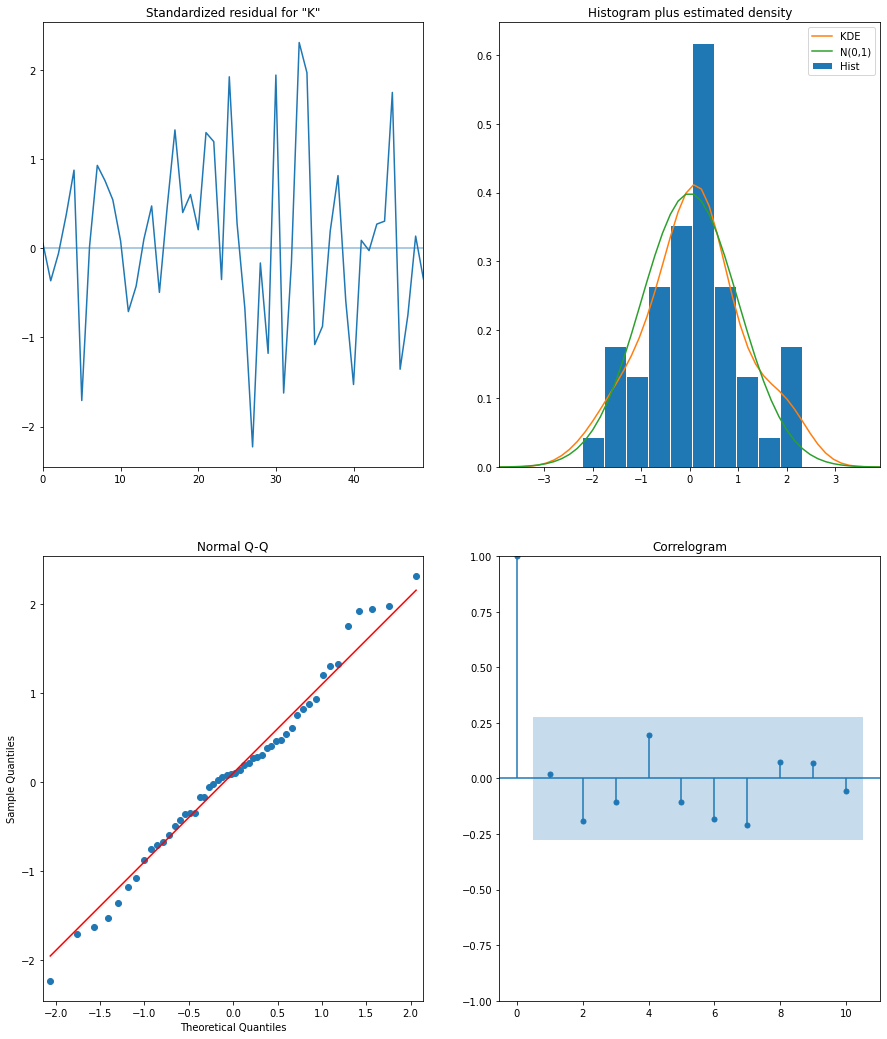

In [74]:
KM_output = sarimax(qb_list[6], qb_list_snaps[6], order=(1, 1, 1), seasonal_order=(1, 1, 1, 16))

The RMSE of our forecasts is 5.71


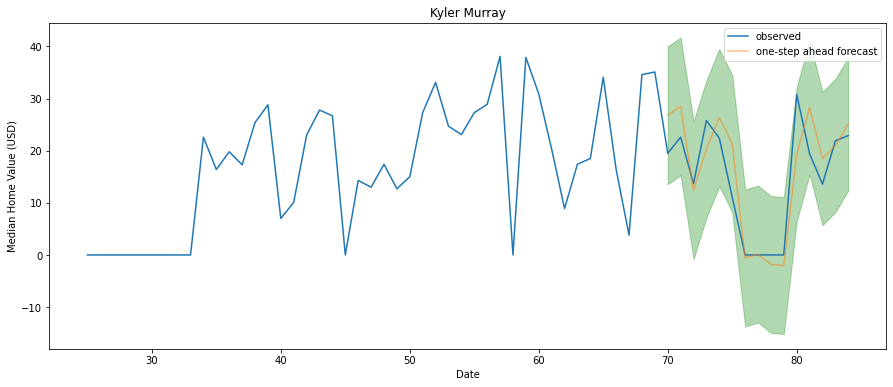

In [75]:
ose_forecast(qb_list[6], KM_output, qb_list_snaps[6][70:], player ='Kyler Murray')

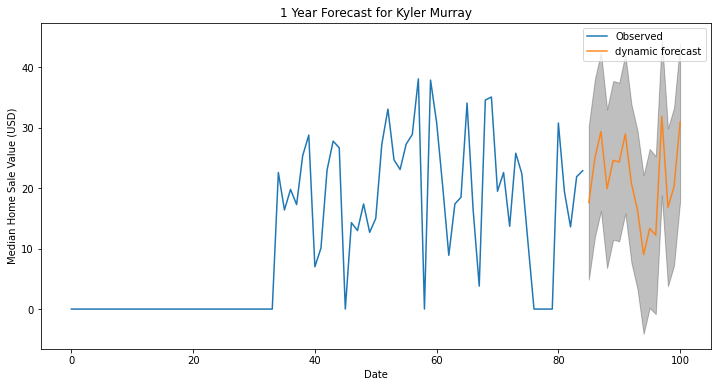

{'forecast': 85     18.0
 86     25.0
 87     29.0
 88     20.0
 89     25.0
 90     24.0
 91     29.0
 92     21.0
 93     16.0
 94      9.0
 95     13.0
 96     12.0
 97     32.0
 98     17.0
 99     20.0
 100    31.0
 Name: predicted_mean, dtype: float64,
 'minimum': 18.0,
 'maximum': 44.0}

In [76]:
dynamic_forecast(qb_list[6], KM_output, qb_list_snaps[6][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[6][-16:].mean()),
                 16, player='Kyler Murray', save_fig=False)


#### Lamar Jackson

                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
snaps_Lamar Jackson     0.2609      0.055      4.726      0.000       0.153       0.369
ar.L1                  -0.0529      0.191     -0.276      0.782      -0.428       0.322
ma.L1                  -0.7305      0.183     -3.984      0.000      -1.090      -0.371
ar.S.L17               -0.5378      0.198     -2.718      0.007      -0.926      -0.150
sigma2                112.8387     27.281      4.136      0.000      59.368     166.309


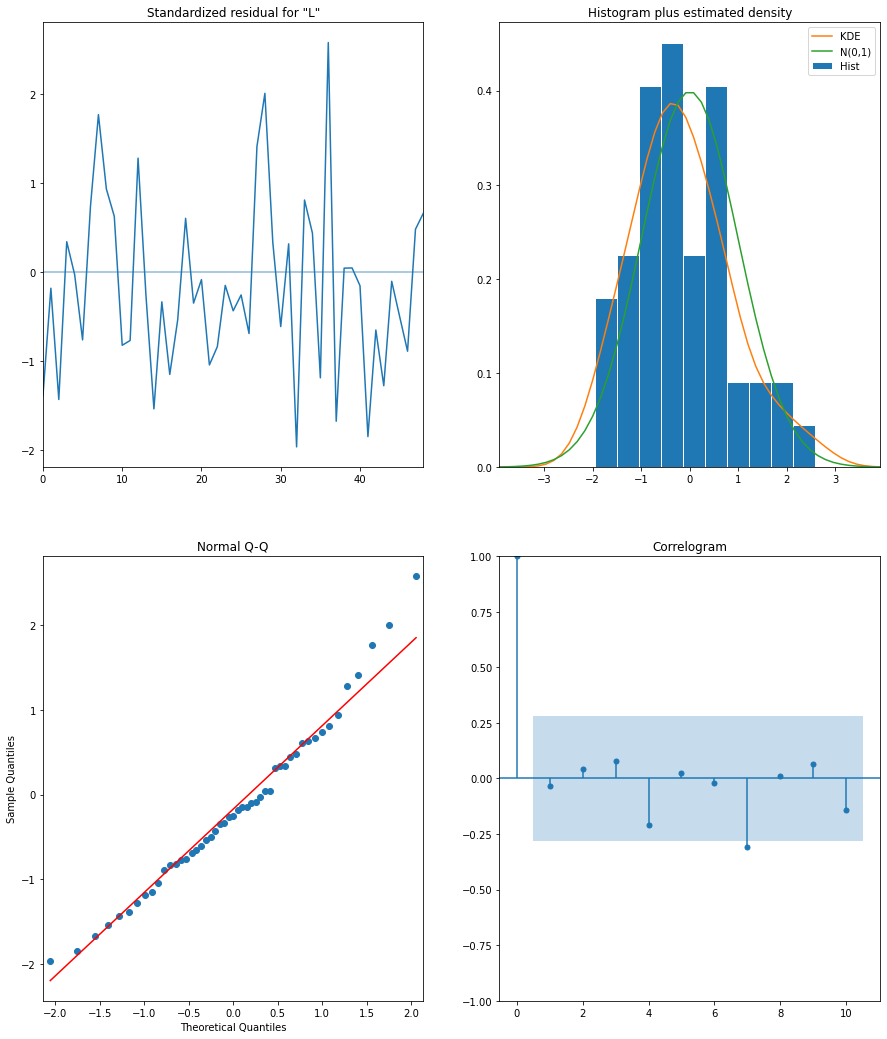

In [77]:
LJ_output = sarimax(qb_list[7], qb_list_snaps[7], order=(1, 1, 1), seasonal_order=(1, 1, 0, 17))

The RMSE of our forecasts is 11.71


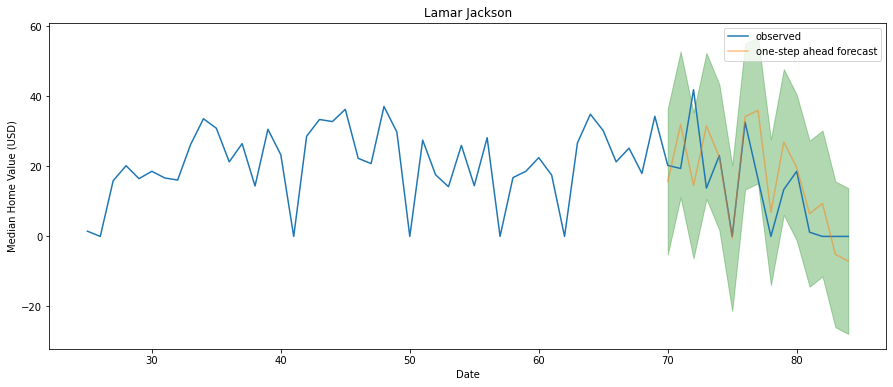

In [78]:
ose_forecast(qb_list[7], LJ_output, qb_list_snaps[7][70:], player ='Lamar Jackson')

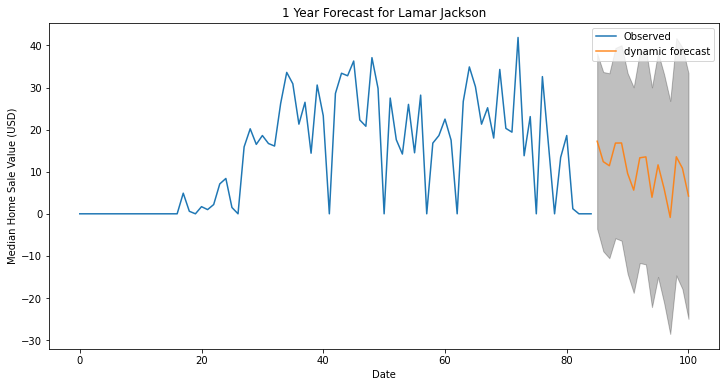

{'forecast': 85     17.0
 86     12.0
 87     11.0
 88     17.0
 89     17.0
 90     10.0
 91      6.0
 92     13.0
 93     14.0
 94      4.0
 95     12.0
 96      6.0
 97     -1.0
 98     14.0
 99     11.0
 100     4.0
 Name: predicted_mean, dtype: float64,
 'minimum': -25.0,
 'maximum': 33.0}

In [79]:
dynamic_forecast(qb_list[7], LJ_output, qb_list_snaps[7][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[7][-16:].mean()),
                 16, player='Lamar Jackson', save_fig=False)


#### Matthew Stafford

                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
snaps_Matthew Stafford     0.2614      0.025     10.655      0.000       0.213       0.310
ar.L1                      0.0755      0.175      0.432      0.666      -0.267       0.418
ma.L1                     -1.0000    706.132     -0.001      0.999   -1384.994    1382.994
ar.S.L17                  -0.5610      0.126     -4.444      0.000      -0.808      -0.314
sigma2                    29.5553   2.09e+04      0.001      0.999   -4.09e+04    4.09e+04


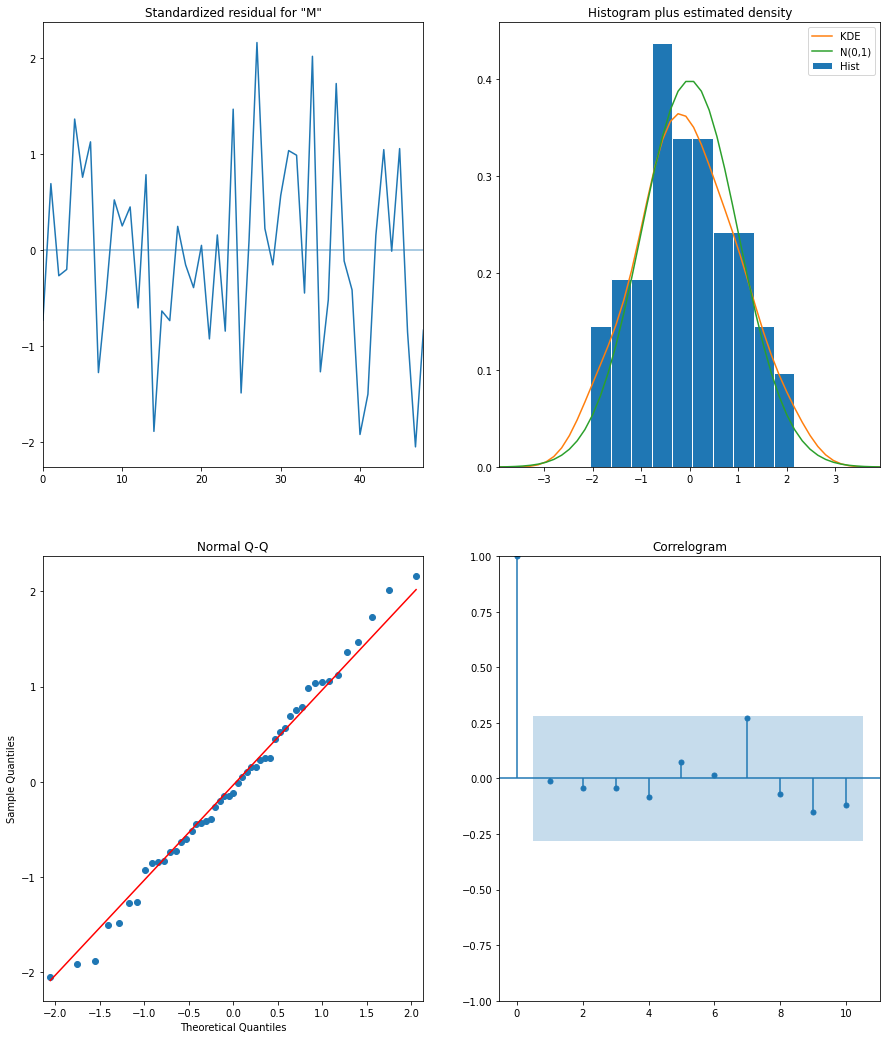

In [80]:
MS_output = sarimax(qb_list[8], qb_list_snaps[8], order=(1, 1, 1), seasonal_order=(1, 1, 0, 17))

The RMSE of our forecasts is 6.79


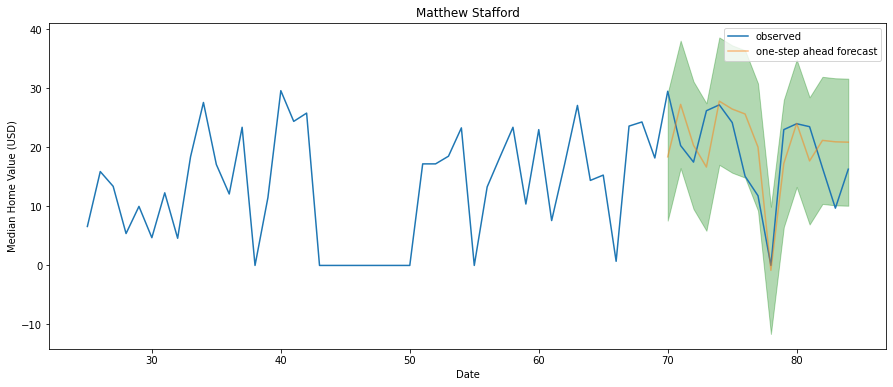

In [81]:
ose_forecast(qb_list[8], MS_output, qb_list_snaps[8][70:], player ='Matthew Stafford')

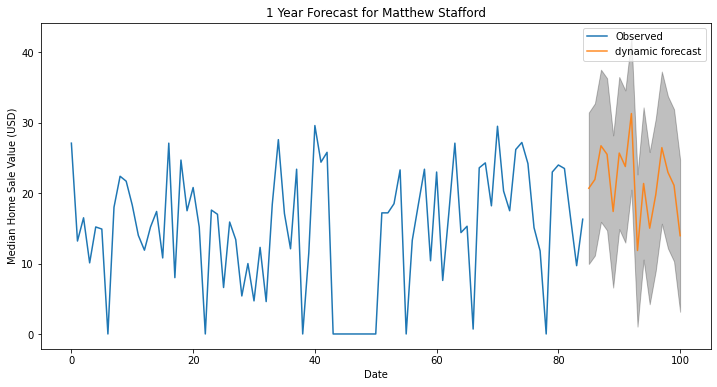

{'forecast': 85     21.0
 86     22.0
 87     27.0
 88     26.0
 89     17.0
 90     26.0
 91     24.0
 92     31.0
 93     12.0
 94     21.0
 95     15.0
 96     20.0
 97     26.0
 98     23.0
 99     21.0
 100    14.0
 Name: predicted_mean, dtype: float64,
 'minimum': 3.0,
 'maximum': 25.0}

In [82]:
dynamic_forecast(qb_list[8], MS_output, qb_list_snaps[8][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[8][-16:].mean()),
                 16, player='Matthew Stafford', save_fig=False)

#### Patrick Mahomes II

                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
snaps_Patrick Mahomes II     0.2593      0.037      6.989      0.000       0.187       0.332
ar.L1                        0.0321      0.125      0.256      0.798      -0.213       0.277
ar.S.L17                    -0.7181      0.118     -6.076      0.000      -0.950      -0.486
sigma2                      62.9274     18.718      3.362      0.001      26.240      99.614


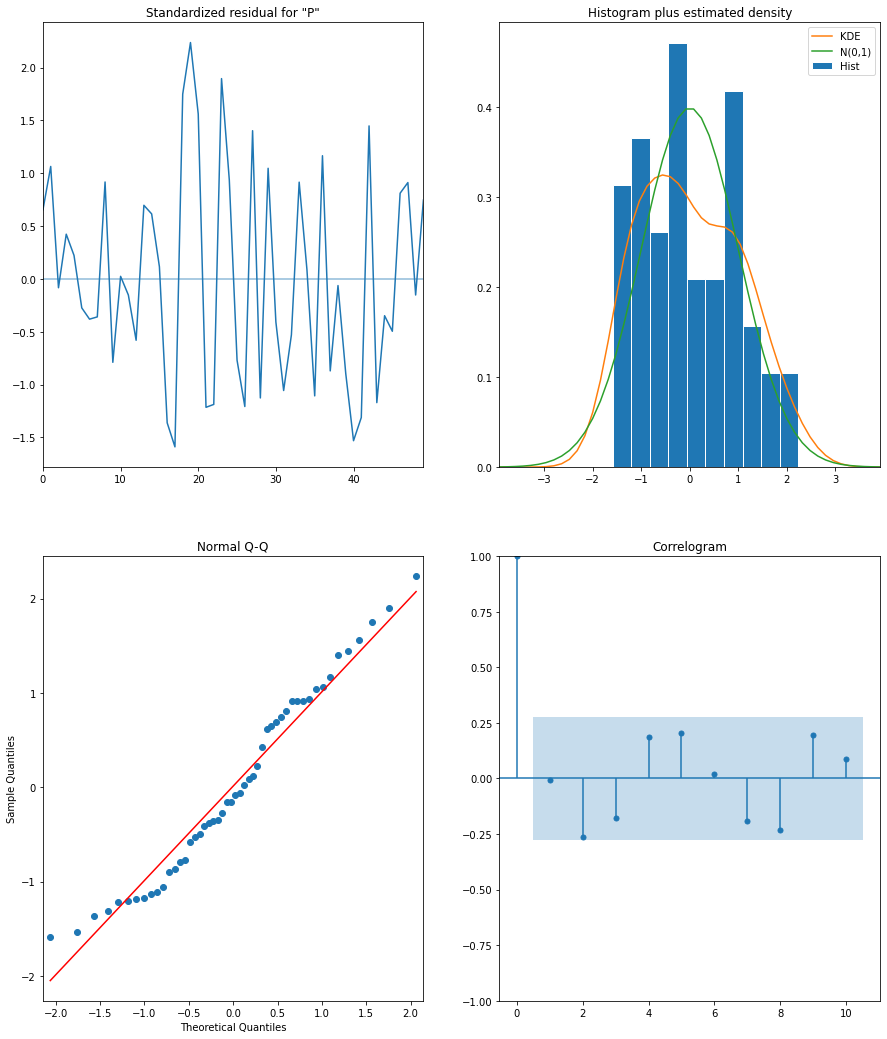

In [83]:
PM_output = sarimax(qb_list[9], qb_list_snaps[9], order=(1, 0, 0), seasonal_order=(1, 1, 0, 17))

The RMSE of our forecasts is 7.7


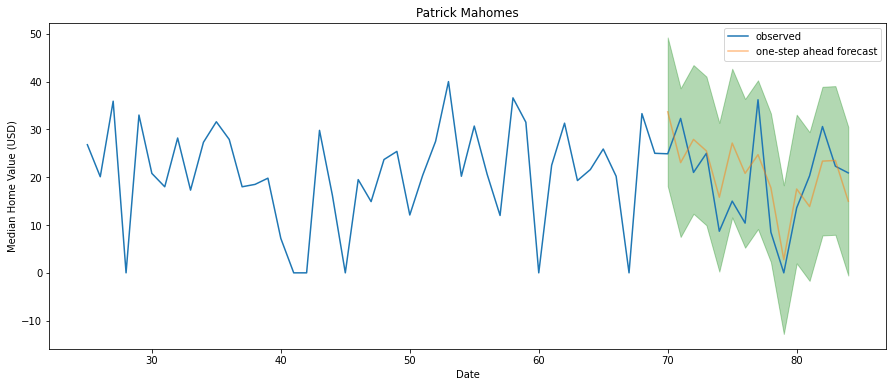

In [84]:
ose_forecast(qb_list[9], PM_output, qb_list_snaps[9][70:], player ='Patrick Mahomes')

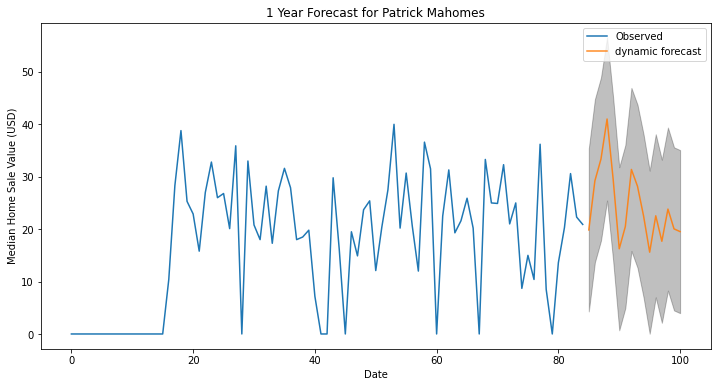

{'forecast': 85     20.0
 86     29.0
 87     33.0
 88     41.0
 89     30.0
 90     16.0
 91     20.0
 92     31.0
 93     28.0
 94     23.0
 95     16.0
 96     23.0
 97     18.0
 98     24.0
 99     20.0
 100    20.0
 Name: predicted_mean, dtype: float64,
 'minimum': 4.0,
 'maximum': 35.0}

In [85]:
dynamic_forecast(qb_list[9], PM_output, qb_list_snaps[9][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[9][-16:].mean()),
                 16, player='Patrick Mahomes', save_fig=False)

#### Russell Wilson

                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
snaps_Russell Wilson     0.3198      0.058      5.501      0.000       0.206       0.434
ma.L1                   -0.9335      0.138     -6.789      0.000      -1.203      -0.664
ar.S.L16                 0.0191      0.016      1.162      0.245      -0.013       0.051
ma.S.L16                -1.0002    655.321     -0.002      0.999   -1285.405    1283.405
sigma2                  39.8682   2.61e+04      0.002      0.999   -5.12e+04    5.13e+04


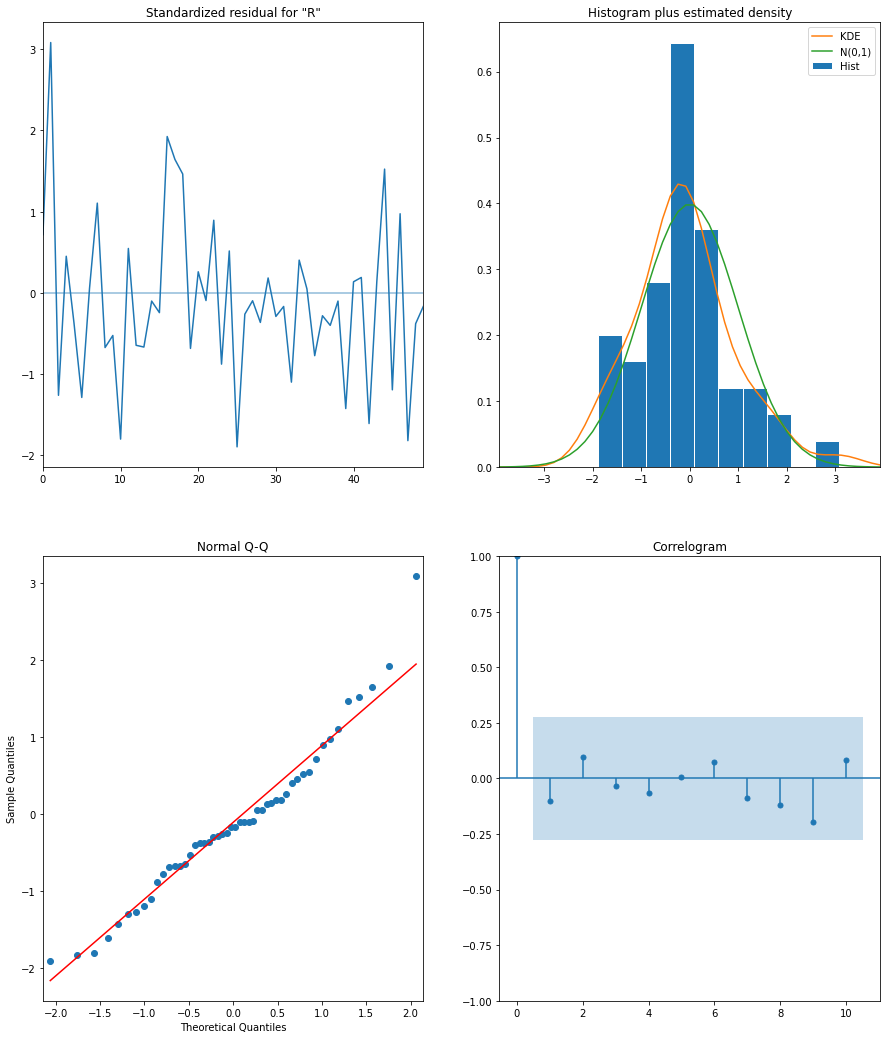

In [170]:
RW_output = sarimax(qb_list[10], qb_list_snaps[10], order=(0, 1, 1), seasonal_order=(1, 1, 1, 16))

The RMSE of our forecasts is 6.87


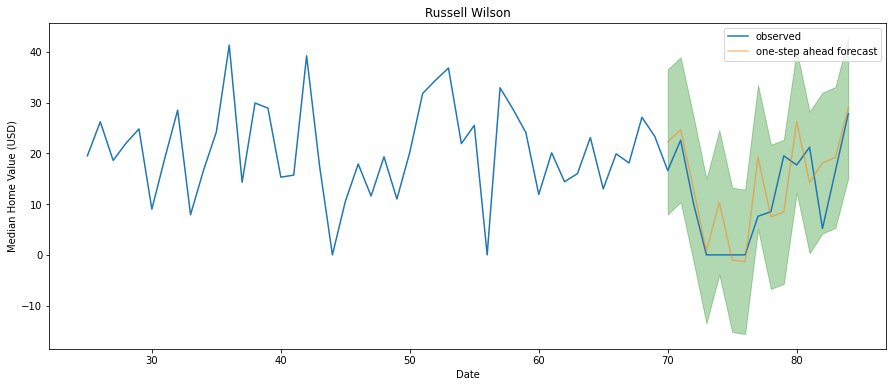

In [171]:
ose_forecast(qb_list[10], RW_output, qb_list_snaps[10][70:], player ='Russell Wilson')

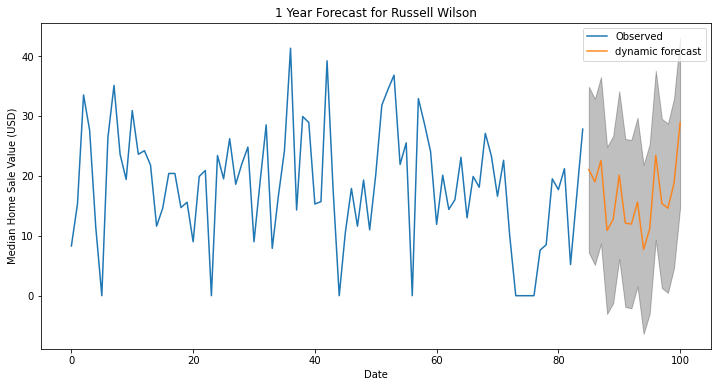

{'forecast': 85     21.0
 86     19.0
 87     23.0
 88     11.0
 89     13.0
 90     20.0
 91     12.0
 92     12.0
 93     16.0
 94      8.0
 95     11.0
 96     23.0
 97     15.0
 98     15.0
 99     19.0
 100    29.0
 Name: predicted_mean, dtype: float64,
 'minimum': 15.0,
 'maximum': 43.0}

In [172]:
dynamic_forecast(qb_list[10], RW_output, qb_list_snaps[10][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[10][-16:].mean()),
                 16, player='Russell Wilson', save_fig=False)

#### Tom Brady

                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
snaps_Tom Brady     0.2432      0.087      2.803      0.005       0.073       0.413
ar.L1              -0.0633      0.188     -0.336      0.737      -0.432       0.305
ma.L1              -0.8815      0.113     -7.796      0.000      -1.103      -0.660
ar.S.L17           -0.7291      0.115     -6.355      0.000      -0.954      -0.504
sigma2             86.1640     19.983      4.312      0.000      46.998     125.330


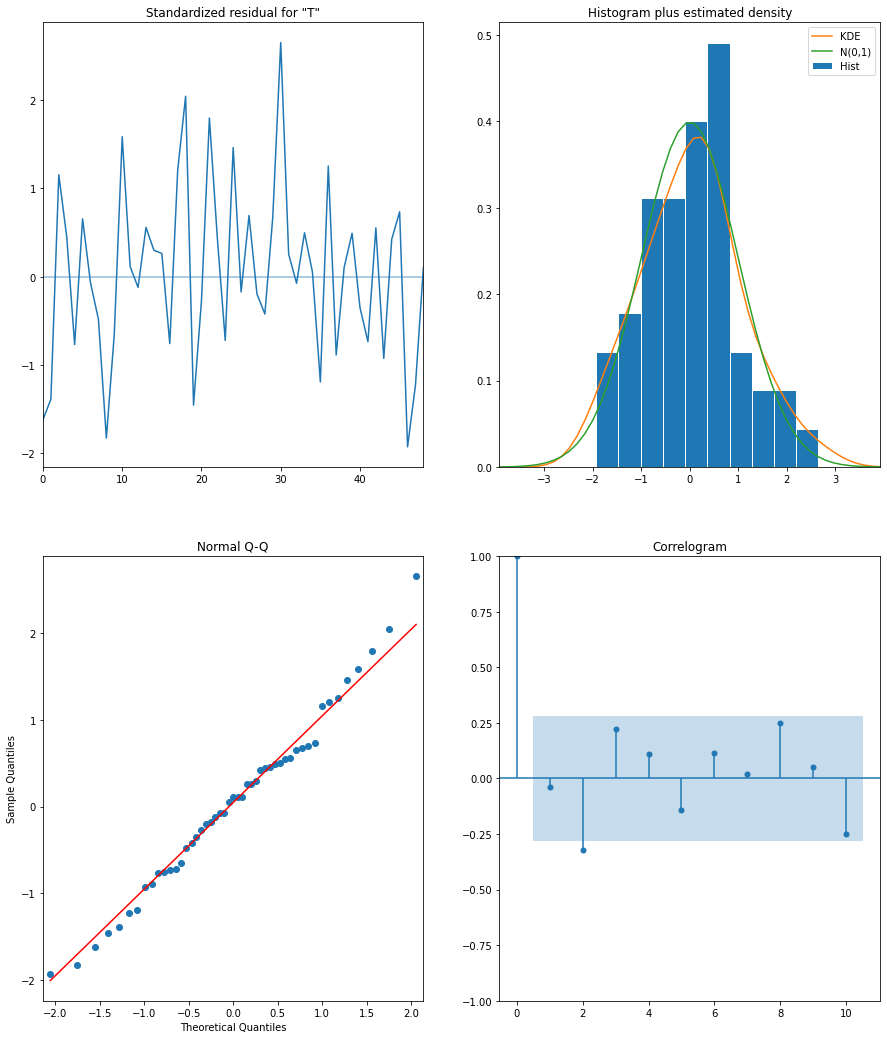

In [89]:
TB_output = sarimax(qb_list[11], qb_list_snaps[11], order=(1, 1, 1), seasonal_order=(1, 1, 0, 17))

The RMSE of our forecasts is 8.24


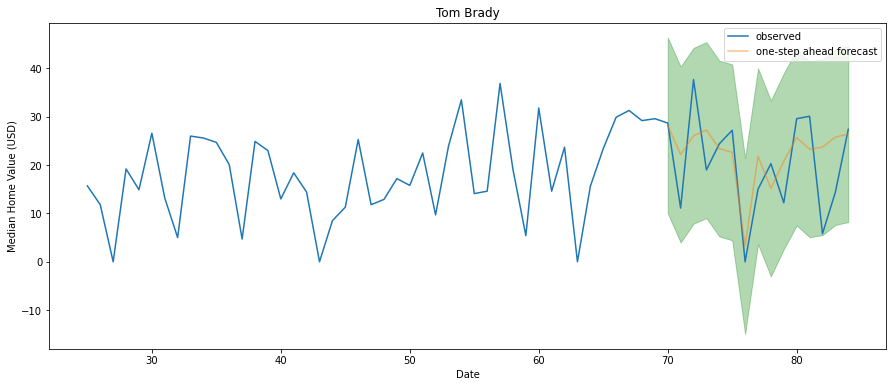

In [90]:
ose_forecast(qb_list[11], TB_output, qb_list_snaps[11][70:], player ='Tom Brady')

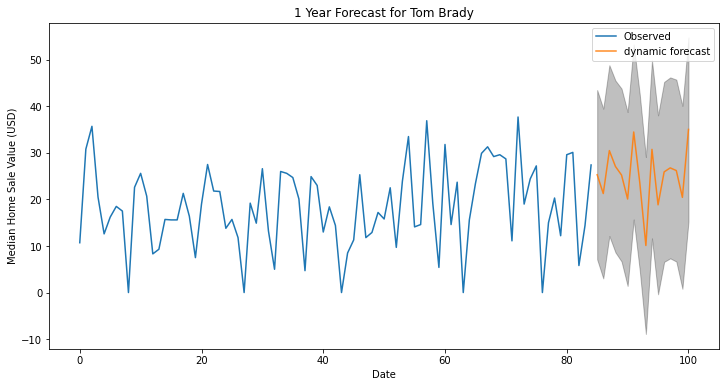

{'forecast': 85     25.0
 86     21.0
 87     30.0
 88     27.0
 89     25.0
 90     20.0
 91     34.0
 92     24.0
 93     10.0
 94     31.0
 95     19.0
 96     26.0
 97     27.0
 98     26.0
 99     20.0
 100    35.0
 Name: predicted_mean, dtype: float64,
 'minimum': 15.0,
 'maximum': 55.0}

In [91]:
dynamic_forecast(qb_list[11], TB_output, qb_list_snaps[11][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[11][-16:].mean()),
                 16, player='Tom Brady', save_fig=False)


#### Trey Lance

                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
snaps_Trey Lance     0.3188      0.141      2.260      0.024       0.042       0.595
ar.L1               -0.0101      0.895     -0.011      0.991      -1.765       1.745
ma.L1               -0.9999     86.600     -0.012      0.991    -170.734     168.734
ar.S.L17         -4.287e-06      0.114  -3.77e-05      1.000      -0.223       0.223
ma.S.L17             0.2193     43.498      0.005      0.996     -85.036      85.475
sigma2               2.6264    227.129      0.012      0.991    -442.538     447.791


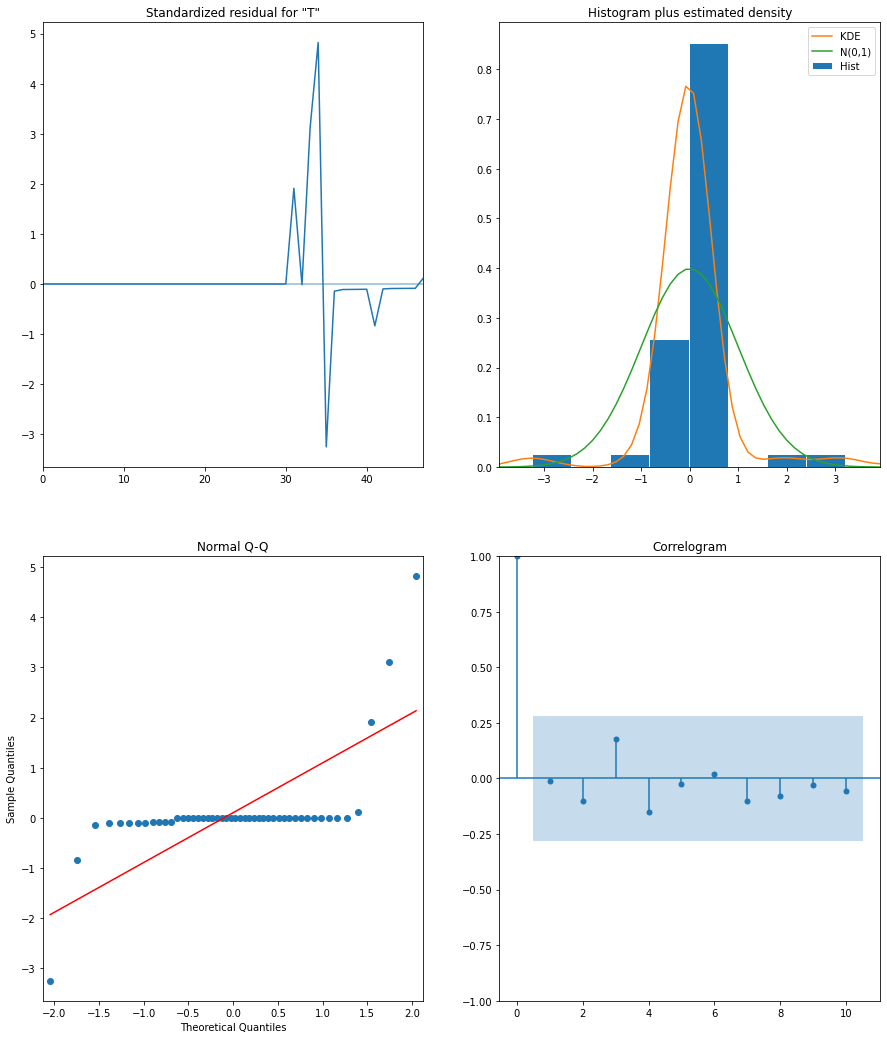

In [92]:
TL_output = sarimax(qb_list[12], qb_list_snaps[12], order=(1, 1, 1), seasonal_order=(1, 1, 1, 17))

The RMSE of our forecasts is 2.81


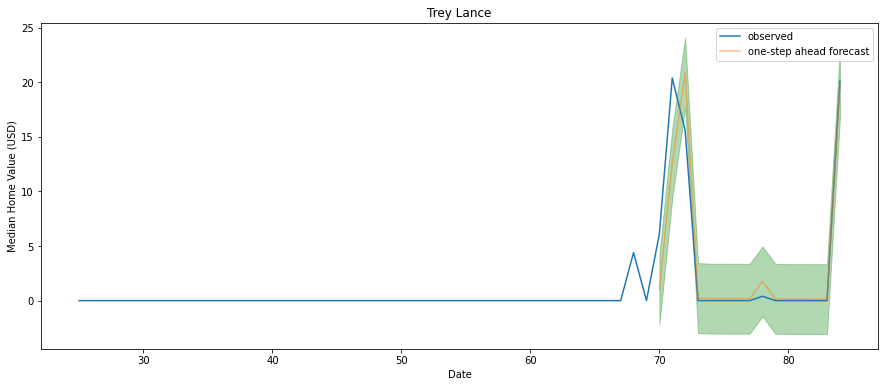

In [93]:
ose_forecast(qb_list[12], TL_output, qb_list_snaps[12][70:], player ='Trey Lance')

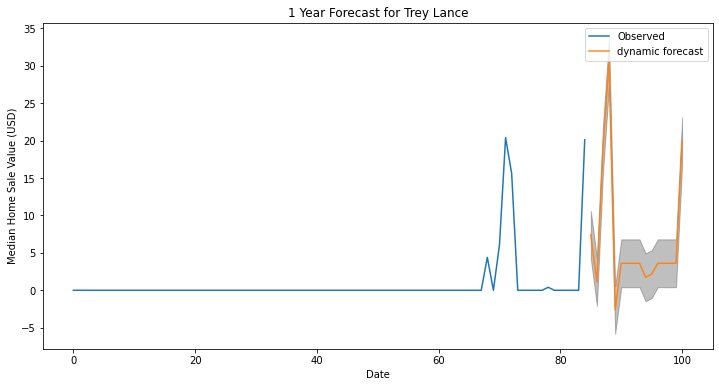

{'forecast': 85      7.0
 86      1.0
 87     19.0
 88     31.0
 89     -3.0
 90      4.0
 91      4.0
 92      4.0
 93      4.0
 94      2.0
 95      2.0
 96      4.0
 97      4.0
 98      4.0
 99      4.0
 100    20.0
 Name: predicted_mean, dtype: float64,
 'minimum': 17.0,
 'maximum': 23.0}

In [94]:
dynamic_forecast(qb_list[12], TL_output, qb_list_snaps[12][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[12][-16:].mean()),
                 16, player='Trey Lance', save_fig=False)


#### Amon Ra St Brown

                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
snaps_Amon-Ra St. Brown     0.1441      0.007     20.747      0.000       0.131       0.158
ar.L1                       1.3670      0.035     39.352      0.000       1.299       1.435
ma.L1                      -1.0000     82.080     -0.012      0.990    -161.874     159.874
sigma2                      4.1256    338.635      0.012      0.990    -659.586     667.837


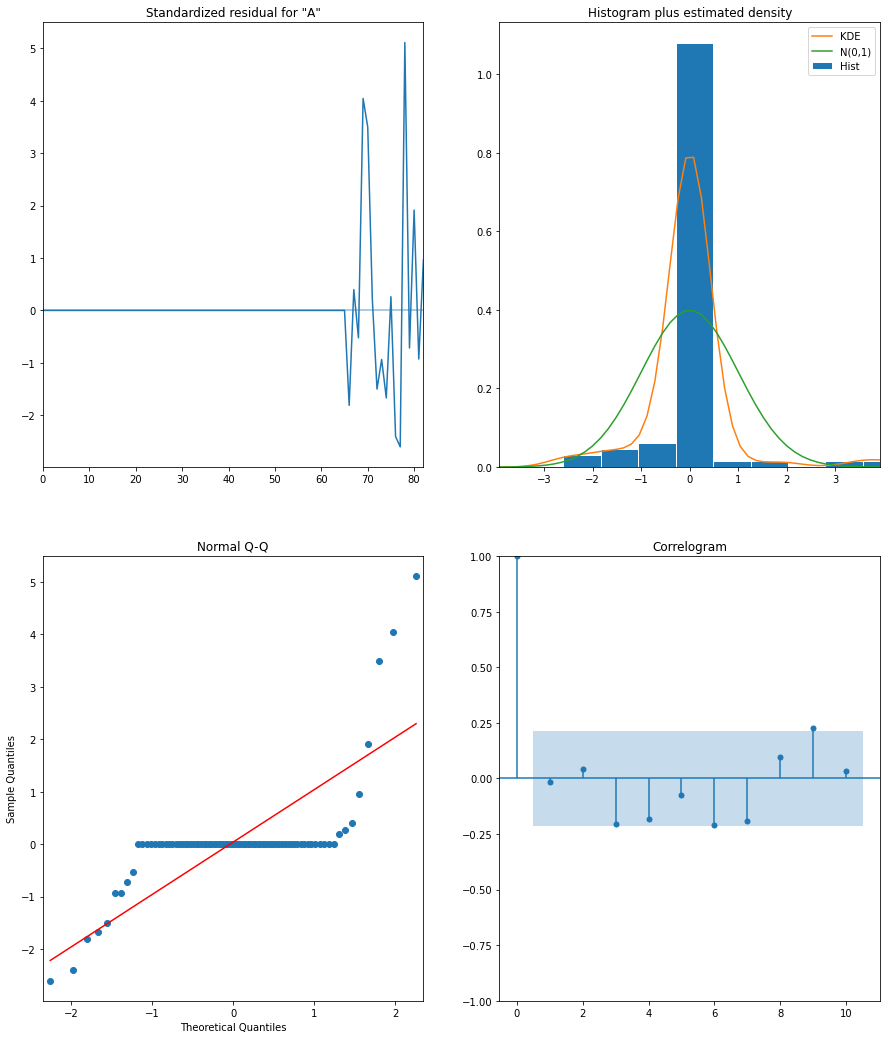

In [241]:
ASB_output = sarimax(wr_list[4], wr_list_snaps[4], order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))


The RMSE of our forecasts is 4.71


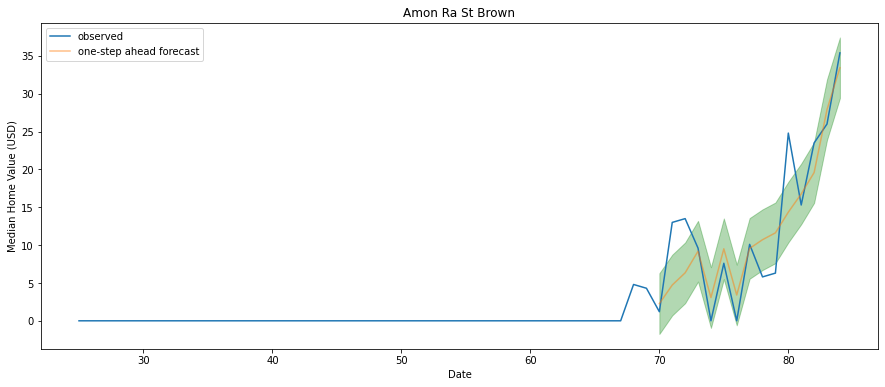

In [243]:
ose_forecast(wr_list[4], ASB_output, wr_list_snaps[4][70:], player ='Amon Ra St Brown')

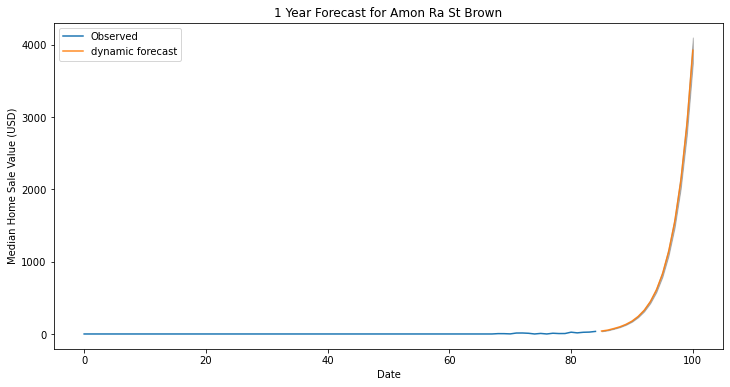

{'forecast': 85       41.0
 86       53.0
 87       75.0
 88       99.0
 89      133.0
 90      178.0
 91      241.0
 92      327.0
 93      445.0
 94      606.0
 95      827.0
 96     1131.0
 97     1539.0
 98     2101.0
 99     2872.0
 100    3922.0
 Name: predicted_mean, dtype: float64,
 'minimum': 3745.0,
 'maximum': 4099.0}

In [244]:
dynamic_forecast(wr_list[4], ASB_output, wr_list_snaps[4][-16:]
                 .replace(to_replace = 0, value = wr_list_snaps[4][-16:].mean()),
                 16, player='Amon Ra St Brown', save_fig=False)

## Facebook Prophet Modeling

In [95]:
qb_fb_list = []
for col in qb_ts.columns:
    player = qb_ts[col].squeeze()
    qb_fb_list.append(player)

qb_fb_list[0]

0     16.5
1     18.5
2     24.8
3     23.1
4     24.0
      ... 
80     0.0
81    29.6
82    23.8
83    20.0
84    20.3
Name: Aaron Rodgers, Length: 85, dtype: float64

In [96]:
# Set the uncertainty interval to 95% (the Prophet default is 80%)
Model = proph(interval_width=0.95)

In [97]:
# Rename the columns [Month, AirPassengers] to [ds, y]
qb_fb_list[0] = qb_fb_list[0].reset_index().rename(columns={'Date': 'ds',
                                                     'Aaron Rodgers': 'y'})
qb_fb_list[0]

,index,y
0,0,16.5
1,1,18.5
2,2,24.8
3,3,23.1
4,4,24.0
...,...,...
80,80,0.0
81,81,29.6
82,82,23.8
83,83,20.0


In [98]:
bye = [6, 23, 44, 55, 76]
qb_fb_list[0] = qb_fb_list[0].drop(bye).fillna(0)
qb_fb_list[0]

,index,y
0,0,16.5
1,1,18.5
2,2,24.8
3,3,23.1
4,4,24.0
...,...,...
80,80,0.0
81,81,29.6
82,82,23.8
83,83,20.0


In [99]:
# Fit the timeseries to Model
Model.fit(qb_fb_list[0])

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [ ]:
# Use make_future_dataframe() with a monthly frequency and periods = 36 for 3 years
future_dates = Model.make_future_dataframe(periods=16, freq='W')
future_dates.head()

In [ ]:
# Predict the values for future dates and take the head of forecast
forecast = Model.predict(future_dates)
forecast.head()

In [ ]:
# Use Prophet's plot method to plot the predictions
Model.plot(forecast, uncertainty=True)
plt.show()

In [ ]:
m = proph()
m.fit(qb_fb_list[0])

#%% Forecast 1 year
weeks = 16
future = m.make_future_dataframe(periods=weeks)
future.tail()

fig1 = m.plot(forecast)
plt.close()
fig2 = m.plot_components(forecast)


## Interpret Results

In [190]:
best_para

,name,pdq,pdqs,aic
3,Aaron Rodgers,"(0, 1, 1)","(0, 0, 0, 0)",628.601789
11,Dak Prescott,"(0, 1, 1)","(0, 0, 0, 0)",632.137618
23,Jalen Hurts,"(1, 1, 1)","(0, 0, 0, 0)",521.944950
31,Joe Burrow,"(1, 1, 1)","(0, 0, 0, 0)",540.091204
35,Josh Allen,"(0, 1, 1)","(0, 0, 0, 0)",615.486900
43,Justin Herbert,"(0, 1, 1)","(0, 0, 0, 0)",567.453035
51,Kyler Murray,"(0, 1, 1)","(0, 0, 0, 0)",602.804424
59,Lamar Jackson,"(0, 1, 1)","(0, 0, 0, 0)",608.302332
71,Matthew Stafford,"(1, 1, 1)","(0, 0, 0, 0)",592.591472
75,Patrick Mahomes II,"(0, 1, 1)","(0, 0, 0, 0)",626.732379


### Projections for 2022 Season

I am now going to make a dataframe that will contain our projected metrics based upon our sarimax model forecasting.

In [218]:
def projections(ts, exog_ts):
    
    '''
    Calculate projections for each zip code.
        - Current Value
        - ROI (return on investment)
        
    Input:
        ts : time series data.
        zipcodes : list of zip codes to iterate through.
        years : n-number of years to forecast.
        
    Output:
        Returns dataframe with:
        - zip code
        - investment value (current value)
        - predicted value and errors
        - predicted ROI and errors

    '''
       
    # Time series of zip code
    player_list = []
    for col in ts.columns:
        player_name = ts[col].squeeze()
        player_list.append(player_name)
               
    player_list_names = []
    for col in ts.columns:
        player_name = col
        player_list_names.append(player_name)    
            
    player_list_snaps = []
    for col in exog_ts.columns:
        player_name = exog_ts[col].squeeze()
        player_list_snaps.append(player_name)
        
        # Define the p, d and q parameters to take any value between 0 and 2
        p = d = q = range(0, 2)
        # Generate all different combinations of p, q and q triplets
        pdq = list(itertools.product(p, d, q))
        # Generate all different combinations of seasonal p, q and q triplets
        pdqs = [(x[0], x[1], x[2], 0) for x in list(itertools.product(p, d, q))]
    
        # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
        ans = []
        for df, name, snaps in zip(player_list, player_list_names, player_list_snaps):
            for comb in pdq:
                for combs in pdqs:
                    try:
                        mod = sm.tsa.statespace.SARIMAX(df,
                                                        exog=qb_snaps,
                                                        order=comb,
                                                        seasonal_order=combs,
                                                        enforce_stationarity=False,
                                                        enforce_invertibility=False)

                        output = mod.fit()
                        ans.append([name, comb, combs, output.aic])
                    except:
                        continue

        # Find the parameters with minimal AIC value
        ans_df = pd.DataFrame(ans, columns=['name', 'pdq', 'pdqs', 'aic'])
        best_para = ans_df.loc[ans_df.groupby("name")["aic"].idxmin()]
        
        # Create list to append projection metrics
        projections = []
        
        # Iterate through time series of each zip code
    
        for df, name, snaps, pdq, pdqs in zip(player_list, player_list_names, player_list_snaps, best_para['pdq'], best_para['pdqs']):
            try:                      
               
                # Plug the optimal parameter values into a new SARIMAX model
                # I used the values that were the most frequent for out top 10 zipcodes
                SARIMAX = sm.tsa.statespace.SARIMAX(df,
                                                    exog=snaps,
                                                    order=pdq,
                                                    seasonal_order=pdqs,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
    

                # Fit the model and print results
                output = SARIMAX.fit()
 
                # Get forecast and confidence interval for steps ahead in future
                forecast = output.get_forecast(steps=16, exog=snaps[-16:].replace(to_replace = 0, value = 61), dynamic=True)
                conf_int = forecast.conf_int()

                # Show prediction for end of step-period
            
                pred_mean = forecast.predicted_mean.sum()
                pred_mean_min = conf_int.iloc[:,0].sum()
                pred_mean_max = conf_int.iloc[:,1].sum()
        
                # Create DataFrame
        
                # Initiate empty dictionary
                predicted = {}

                # Columns for df
                predicted['Player'] = name
                predicted['Projected Points'] = pred_mean.round(0)
                predicted['Min Projected Points'] = pred_mean_min.round(0)
                predicted['Max Projected Points'] = pred_mean_max.round(0)
                
                # Append to list
                projections.append(predicted)
            except:
                continue
        
    # Return in DataFrame format     
    return pd.DataFrame(projections)

In [211]:
projections(qb_ts, qb_snap_ts)

,Player,Projected Points,Min Projected Points,Max Projected Points
0,Aaron Rodgers,343.0,116.0,570.0
1,Dak Prescott,322.0,81.0,564.0
2,Jalen Hurts,346.0,263.0,429.0
3,Joe Burrow,319.0,174.0,463.0
4,Josh Allen,384.0,163.0,605.0
5,Justin Herbert,347.0,195.0,499.0
6,Kyler Murray,343.0,170.0,515.0
7,Lamar Jackson,280.0,30.0,529.0
8,Matthew Stafford,301.0,113.0,489.0
9,Patrick Mahomes II,378.0,161.0,595.0


In [219]:
projections(rb_ts, rb_snap_ts)

,Player,Projected Points,Min Projected Points,Max Projected Points
0,AJ Dillon,213.0,130.0,297.0
1,Aaron Jones,285.0,2.0,568.0
2,Alvin Kamara,365.0,36.0,693.0
3,Antonio Gibson,259.0,140.0,378.0
4,Austin Ekeler,341.0,135.0,546.0
5,Breece Hall,0.0,-0.0,0.0
6,Cam Akers,-2.0,-121.0,116.0
7,Chase Edmonds,81.0,-139.0,301.0
8,Christian McCaffrey,42.0,-403.0,487.0
9,Clyde Edwards-Helaire,104.0,-120.0,329.0


In [214]:
projections(wr_ts, wr_snap_ts)

,Player,Projected Points,Min Projected Points,Max Projected Points
0,A.J. Brown,255.0,54.0,455.0
1,Adam Thielen,246.0,15.0,477.0
2,Allen Robinson II,145.0,-60.0,350.0
3,Amari Cooper,231.0,-63.0,524.0
4,Amon-Ra St. Brown,14595.0,13929.0,15261.0
5,Brandin Cooks,227.0,-11.0,465.0
6,Brandon Aiyuk,189.0,77.0,300.0
7,CeeDee Lamb,251.0,106.0,395.0
8,Chris Godwin,256.0,19.0,493.0
9,Christian Kirk,177.0,-19.0,372.0


In [215]:
projections(te_ts, te_snap_ts)

,Player,Projected Points,Min Projected Points,Max Projected Points
0,Dallas Goedert,165.0,15.0,315.0
1,Dalton Schultz,176.0,34.0,318.0
2,Darren Waller,230.0,51.0,408.0
3,Dawson Knox,146.0,32.0,260.0
4,George Kittle,243.0,-1.0,487.0
5,Kyle Pitts,211.0,74.0,348.0
6,Mark Andrews,277.0,61.0,492.0
7,T.J. Hockenson,185.0,51.0,319.0
8,Travis Kelce,274.0,49.0,500.0
9,Zach Ertz,157.0,-66.0,381.0


In [345]:
SARIMAX = sm.tsa.statespace.SARIMAX(qb_list[0],
                                    exog=qb_list_snaps[0],
                                    order=(1,1,1),
                                    seasonal_order=(1,1,0,17),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)


# Fit the model and print results
output = SARIMAX.fit()
 
# Get forecast and confidence interval for steps ahead in future
forecast = output.get_forecast(steps=16, exog=qb_list_snaps[0][-16:], dynamic=True)
conf_int = forecast.conf_int()

# Show prediction for end of step-period
pred_mean = forecast.predicted_mean.sum()
pred_mean_min = conf_int.iloc[:,0].sum()
pred_mean_max = conf_int.iloc[:,1].sum()
conf_int

,lower Aaron Rodgers,upper Aaron Rodgers
85,3.146655,42.133159
86,3.620047,42.952888
87,8.130333,47.522120
88,9.602164,49.038622
89,1.498239,40.978137
90,-6.388938,33.134245
91,13.437740,53.004153
92,-21.104871,18.504723
93,11.866633,51.519360
94,0.095599,39.791414


### Barplots of 2022 Season Projections and Errors

In [ ]:
# Barplot for x years projection with 95% confidence intervals
def projection_barplot(df, years=3, save_fig=False):
    # Plot Predicted Mean Home Sale Values #

    # Get errors; (pred mean - lower bound of conf interval)
    errors = df['Predicted ROI (%)'] - df['Min Pred ROI (%)']
    df['errors'] = errors

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot barplot of ROI with errors
    plt.rcParams.update({'font.size': 18})
    df.plot(x='Neighborhood', 
            y='Predicted ROI (%)', 
            kind='bar',
            ax=ax, 
            color='none', 
            ecolor='black',
            capsize=10,
            yerr='errors', 
            legend=False)
    #Labels
    ax.set_xlabel('Neighborhood')
    ax.set_ylabel('Predicted ROI (%)')
    plt.title(f'{years} Year ROI w/ 95% Confidence Intervals')

    # Predicted ROI
    ax.scatter(x=pd.np.arange(df.shape[0]),
               marker='s', 
               s=40, 
               y=df['Predicted ROI (%)'], 
               color='black')
    
    # Line to help visualize on the y-axis
    ax.axhline(y=50, linestyle='--', color='red', linewidth=1.5)
    
    if save_fig:
        fig.savefig(f'./images/barplot_{years}.jpeg')
    
    # Rotate zip code labels 45 degrees
    plt.xticks(rotation = 45, size = 14)
    plt.show();

## Recommendations

## Future Work